In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates

import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.colors import LogNorm

from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.ticker                         # here's where the formatter is
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

from astropy.visualization import (MinMaxInterval, SqrtStretch,ZScaleInterval,PercentileInterval,
                                   ImageNormalize,imshow_norm)
from astropy.visualization.stretch import SinhStretch, LinearStretch,AsinhStretch,LogStretch


from astropy.io import fits




In [2]:
# Assembly task
# https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/isrTask.py

from lsst.ip.isr.assembleCcdTask import (AssembleCcdConfig, AssembleCcdTask)
from lsst.ip.isr.isrTask import (IsrTask, IsrTaskConfig)

#https://github.com/lsst/ip_isr/blob/main/python/lsst/ip/isr/overscan.py
from lsst.ip.isr import  OverscanCorrectionTaskConfig, OverscanCorrectionTask

In [3]:
# LSST Display
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib')

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
! eups list -s

afw                   gb62437fd66+a272651890 	current w_2023_39 setup
alert_packet          g6041bd2d66 	current w_2023_39 setup
analysis_drp          g8a53795882+852a24a654 	current w_2023_39 setup
analysis_tools        g92b6ad8a5b+40272a923a 	current w_2023_39 setup
ap_association        g6a6fcd37b7+f5af200bc5 	current w_2023_39 setup
ap_pipe               g9f065385ad+090559a986 	current w_2023_39 setup
ap_verify             g60239a501b+ad285bcdbf 	current w_2023_39 setup
astro_metadata_translator g0978aabd1f+0ffa813159 	current w_2023_39 setup
astshim               g3273194fdb+f6908454ef 	current w_2023_39 setup
atmospec              LOCAL:/home/m/monroy/repos/repos_w_2023_35/atmospec 	setup
base                  g98ffbb4407+81bc2a20b4 	current w_2023_39 setup
cbp                   ga32fcf49c8+1b73362753 	current w_2023_39 setup
cell_coadds           g9faf7ed3f3+852a24a654 	current w_2023_39 setup
coadd_utils           g337abbeb29+1b73362753 	current w_2023_39 setup
cp_pipe         

# Butler 

In [6]:
import lsst.daf.butler as dafButler

In [7]:
embargo = True

In [8]:
if embargo:
    repo="/sdf/group/rubin/repo/oga/"
else:
    repo = "/sdf/group/rubin/repo/main"
butler = dafButler.Butler(repo)
registry = butler.registry

In [9]:
cameraName = 'LATISS'
'''
calibCollections = ['LATISS/defaults','LATISS/raw/all']
for col in registry.queryCollections("*LATISS/calib*"):
    #print(col)
    calibCollections.append(col)
'''
calibCollections = ['LATISS/calib','LATISS/raw/all']

# Paths 

In [10]:
outdir_base0 = '../../output_special_flats/'
if os.path.exists(outdir_base0)==False:
    os.mkdir(outdir_base0)
outdir_base = os.path.join(outdir_base0,'shifting_star_flats')
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)
outdir_label = 'horizontal_shift_{0}/'

We check the different dimension records existing for *physical_filter*: 

In [11]:
phys_filters = list(registry.queryDimensionRecords('physical_filter',where="instrument='LATISS'"))

Print physical_filters with hologram in place: 

In [12]:
for f_ in phys_filters:
    if 'holo' in f_.name:
        print(f_.name)

empty~holo4_003
blank_bk7_wg05~holo4_003
KPNO_1111_436nm~holo4_003
KPNO_373A_677nm~holo4_003
KPNO_406_828nm~holo4_003
unknown~holo4_003
BG40~holo4_003
quadnotch1~holo4_003
RG610~holo4_003
FELH0600~holo4_003
SDSSg~holo4_003
SDSSr~holo4_003
SDSSi~holo4_003
BG40_65mm_1~holo4_003
BG40_65mm_2~holo4_003
OG550_65mm_1~holo4_003
OG550_65mm_2~holo4_003
SDSSg_65mm~holo4_003
SDSSr_65mm~holo4_003
SDSSi_65mm~holo4_003
SDSSu_65mm~holo4_003
SDSSz_65mm~holo4_003
SDSSy_65mm~holo4_003
empty~holo4_001
blank_bk7_wg05~holo4_001
KPNO_1111_436nm~holo4_001
KPNO_373A_677nm~holo4_001
KPNO_406_828nm~holo4_001
unknown~holo4_001
BG40~holo4_001
BG40_65mm_1~holo4_001
BG40_65mm_2~holo4_001
quadnotch1~holo4_001
RG610~holo4_001
OG550_65mm_1~holo4_001
OG550_65mm_2~holo4_001
FELH0600~holo4_001
SDSSg~holo4_001
SDSSr~holo4_001
SDSSi~holo4_001
SDSSu_65mm~holo4_001
SDSSg_65mm~holo4_001
SDSSr_65mm~holo4_001
SDSSi_65mm~holo4_001
SDSSz_65mm~holo4_001
SDSSy_65mm~holo4_001
collimator~holo4_003
collimator~holo4_001
cyl_lens~holo4_0

## Retrive exposures corresponding to the run we are interested in 

In [13]:
obs_type = 'science'
obs_day = 20230926
physical_filter = 'empty~holo4_003' 
science_program = 'BLOCK-102'

In [14]:
df_science = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num','time_start',
                                    'time_end' ,'type', 'target','filter_disp','zenith_angle',
                                    'exp_time','ra','dec','skyangle','science_program'])

In [15]:

where_exps = "instrument='LATISS' AND exposure.observation_type='{0}' AND exposure.day_obs={1} AND physical_filter='{2}' AND exposure.science_program='{3}'".format(obs_type,obs_day,physical_filter,science_program)
for i, info in enumerate(registry.queryDimensionRecords('exposure',where=where_exps)):
    
    #if info.observation_type=='science':
    id_ = info.id
    obs_id_ = info.obs_id
    day_obs_ = info.day_obs
    seq_num_ = info.seq_num
    timespan_ = info.timespan
    timespan_begin_ = pd.to_datetime(timespan_.begin.to_string())
    timespan_end_ = pd.to_datetime(timespan_.end.to_string())
    timespan_begin_jd_ = timespan_.begin.jd
    timespan_begin_mjd_ = timespan_.begin.mjd

    observation_type_ = info.observation_type
    target_name_ = info.target_name
    physical_filter_ = info.physical_filter
    zenith_angle_ = info.zenith_angle
    exposure_time_ = info.exposure_time
    tracking_ra_ = info.tracking_ra
    tracking_dec_ = info.tracking_dec
    sky_angle_ = info.sky_angle
    science_program_ = info.science_program

    df_science.loc[i] = [id_, obs_id_, day_obs_, seq_num_,timespan_begin_,timespan_end_ ,observation_type_, \
                         target_name_, physical_filter_, zenith_angle_, exposure_time_,tracking_ra_, \
                         tracking_dec_, sky_angle_, science_program_]

    if i < 2:
        print(i)
        print(info)
        print("\t timespan:            ",info.timespan)
        print("\t timespan.begin:      ",info.timespan.begin)
        print("\t id:                  ",info.id)
        print("\t day_obs:             ",info.day_obs)
        print("\t seq_num:             ",info.seq_num)
        print("\t type-of-observation: ",info.observation_type)
        print("\t target:              ",info.target_name)
        print("-----------------------------------------------------")
    

0
exposure:
  instrument: 'LATISS'
  id: 2023092600446
  physical_filter: 'empty~holo4_003'
  obs_id: 'AT_O_20230926_000446'
  exposure_time: 30.0
  dark_time: 30.2346
  observation_type: 'science'
  observation_reason: 'sitcom-1043'
  day_obs: 20230926
  seq_num: 446
  seq_start: 446
  seq_end: 446
  group_name: '2023-09-27T02:51:35.414'
  group_id: 2757126954140000
  target_name: 'HD2811'
  science_program: 'BLOCK-102'
  tracking_ra: 7.827800206545046
  tracking_dec: -43.60460268648411
  sky_angle: 19.097270869928906
  azimuth: 127.53812441035177
  zenith_angle: 27.05391872351369
  has_simulated: False
  timespan: Timespan(begin=astropy.time.Time('2023-09-27 02:54:18.911003', scale='tai', format='iso'), end=astropy.time.Time('2023-09-27 02:54:49.146000', scale='tai', format='iso'))
	 timespan:             [2023-09-27T02:54:18.911003, 2023-09-27T02:54:49.146000)
	 timespan.begin:       2023-09-27 02:54:18.911003
	 id:                   2023092600446
	 day_obs:              20230926
	 

In [16]:
print('Number of entries = ',len(df_science))

Number of entries =  68


In [17]:
df_science.tail(5)

id                obs_id   day_obs  seq_num  \
63  2023092600512  AT_O_20230926_000512  20230926      512   
64  2023092600513  AT_O_20230926_000513  20230926      513   
65  2023092600514  AT_O_20230926_000514  20230926      514   
66  2023092600515  AT_O_20230926_000515  20230926      515   
67  2023092600516  AT_O_20230926_000516  20230926      516   

                   time_start                time_end     type  target  \
63 2023-09-27 03:42:47.848997 2023-09-27 03:42:58.081  science  HD2811   
64 2023-09-27 03:43:21.583998 2023-09-27 03:43:31.825  science  HD2811   
65 2023-09-27 03:43:44.508999 2023-09-27 03:43:54.753  science  HD2811   
66 2023-09-27 03:44:18.201997 2023-09-27 03:44:28.438  science  HD2811   
67 2023-09-27 03:44:41.214988 2023-09-27 03:44:51.445  science  HD2811   

        filter_disp  zenith_angle  exp_time        ra        dec   skyangle  \
63  empty~holo4_003     19.270444      10.0  7.829349 -43.603302  31.841295   
64  empty~holo4_003     19.188712      10.0  7.830427 -43.602159  31.841293   
65  empty~holo4_003     19.133679      10.0  7.830462 -43.602179  31.841334   
66  empty~holo4_003     19.054660      10.0  7.831341 -43.600949  31.841343   
67  empty~holo4_003     18.999954      10.0  7.831390 -43.600935  31.841309   

   science_program  
63       BLOCK-102  
64       BLOCK-102  
65       BLOCK-102  
66       BLOCK-102  
67       BLOCK-102

Select exposures: 

In [18]:
seq_nums = np.sort(np.array(df_science.seq_num))
print(seq_nums)

[446 447 448 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463
 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479 480 481
 485 486 487 488 489 490 491 492 493 494 495 496 497 498 499 500 501 502
 503 504 505 506 507 508 509 510 511 512 513 514 515 516]


In [19]:
ids = np.sort(np.array(df_science.id))
print(ids)

[2023092600446 2023092600447 2023092600448 2023092600449 2023092600450
 2023092600451 2023092600452 2023092600453 2023092600454 2023092600455
 2023092600456 2023092600457 2023092600458 2023092600459 2023092600460
 2023092600461 2023092600462 2023092600463 2023092600464 2023092600465
 2023092600466 2023092600467 2023092600468 2023092600469 2023092600470
 2023092600471 2023092600472 2023092600473 2023092600474 2023092600475
 2023092600476 2023092600477 2023092600478 2023092600479 2023092600480
 2023092600481 2023092600485 2023092600486 2023092600487 2023092600488
 2023092600489 2023092600490 2023092600491 2023092600492 2023092600493
 2023092600494 2023092600495 2023092600496 2023092600497 2023092600498
 2023092600499 2023092600500 2023092600501 2023092600502 2023092600503
 2023092600504 2023092600505 2023092600506 2023092600507 2023092600508
 2023092600509 2023092600510 2023092600511 2023092600512 2023092600513
 2023092600514 2023092600515 2023092600516]


## Select exposures given by notebook *retrive_and_select_exposures_20230926* 

In [20]:
seq_nums_selected = np.arange(462,487)
print(seq_nums_selected)

[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 482 483 484 485 486]


In [21]:
seq_mask = np.in1d(seq_nums,seq_nums_selected)

In [22]:
seq_nums = seq_nums[seq_mask]
ids = ids[seq_mask]

In [23]:
print(seq_nums)
print(ids)

[462 463 464 465 466 467 468 469 470 471 472 473 474 475 476 477 478 479
 480 481 485 486]
[2023092600462 2023092600463 2023092600464 2023092600465 2023092600466
 2023092600467 2023092600468 2023092600469 2023092600470 2023092600471
 2023092600472 2023092600473 2023092600474 2023092600475 2023092600476
 2023092600477 2023092600478 2023092600479 2023092600480 2023092600481
 2023092600485 2023092600486]


We test retrieving one of them: 

In [24]:
seq_num0 = seq_nums[2]
exp_id0 = ids[2]
print(exp_id0)

2023092600464


In [25]:
test_img = butler.get('raw', dataId={'exposure': exp_id0, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)

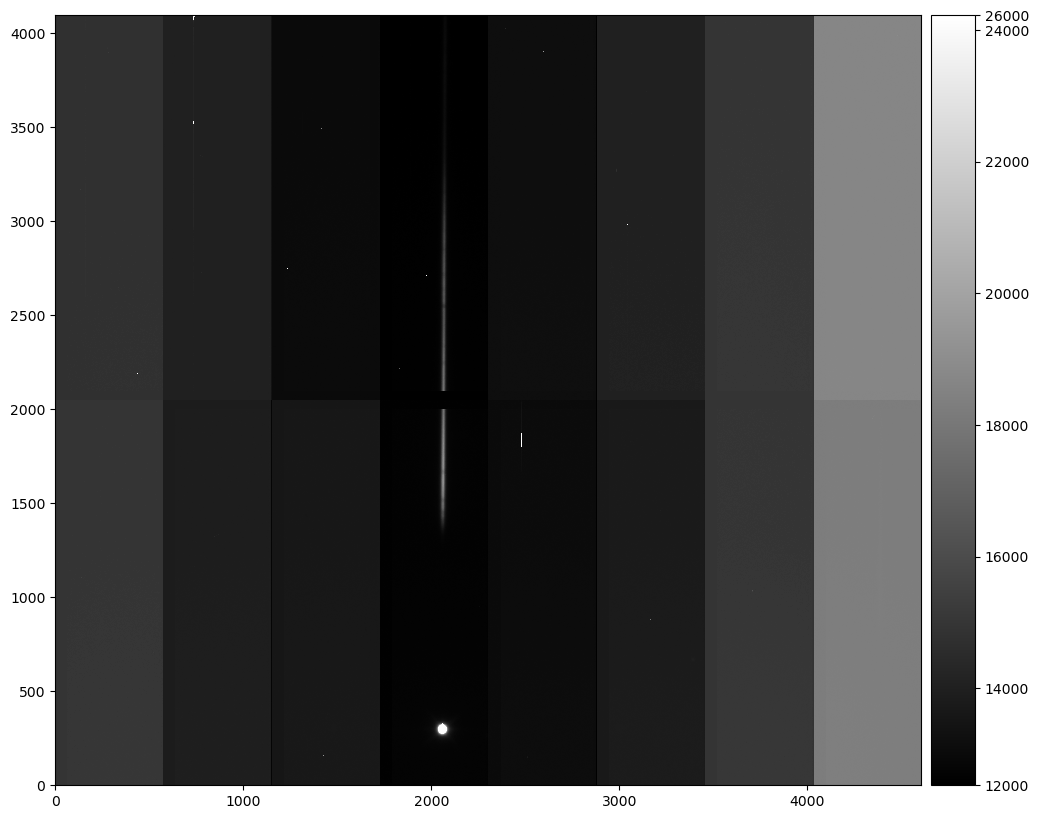

In [26]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(test_img.image)

In [27]:
md = test_img.getMetadata().toDict()

In [28]:
md['EXPTIME']

30.0

## Set exposure time for all exposures 

We reject those with diffent exposure times 

In [29]:
exp_time = 30.

## Organize amplifiers 

In [30]:
ampli_boxes = {}
ampli_names = []
for ampIdx, amp in enumerate(test_img.getDetector()):
    ampli_name_ = amp.getName()
    ampli_names.append(ampli_name_)
    xbegin = amp.getBBox().x.begin
    xend = amp.getBBox().x.end
    ybegin = amp.getBBox().y.begin
    yend = amp.getBBox().y.end
    ampli_boxes[ampli_name_] = (xbegin,xend,ybegin,yend)

In [31]:
ampli_boxes

{'C10': (0, 509, 2000, 4000),
 'C11': (509, 1018, 2000, 4000),
 'C12': (1018, 1527, 2000, 4000),
 'C13': (1527, 2036, 2000, 4000),
 'C14': (2036, 2545, 2000, 4000),
 'C15': (2545, 3054, 2000, 4000),
 'C16': (3054, 3563, 2000, 4000),
 'C17': (3563, 4072, 2000, 4000),
 'C07': (3563, 4072, 0, 2000),
 'C06': (3054, 3563, 0, 2000),
 'C05': (2545, 3054, 0, 2000),
 'C04': (2036, 2545, 0, 2000),
 'C03': (1527, 2036, 0, 2000),
 'C02': (1018, 1527, 0, 2000),
 'C01': (509, 1018, 0, 2000),
 'C00': (0, 509, 0, 2000)}

We do the ISR on this image the same way we do it with the spectra images (i.e., we do our pseudo-postISRCCD): 

In [32]:
# configuration
isr_config =  IsrTaskConfig()

In [33]:
isr_config.doDark = False
isr_config.doFlat =  False
isr_config.doFringe = False
isr_config.doDefect = True
isr_config.doLinearize = False
isr_config.doCrosstalk =  False
isr_config.doSaturationInterpolation = False
isr_config.overscan.fitType: 'MEDIAN_PER_ROW'
isr_config.doBias: True


In [34]:
isr_task = IsrTask(config=isr_config)

In [35]:
butler = dafButler.Butler(repo, collections=calibCollections)
camera = butler.get('camera', instrument=cameraName)
#bias = butler.get('bias',instrument=cameraName,detector=0)
#defects = butler.get('defects',instrument=cameraName,detector=0)

In [36]:

bias = butler.get("bias",instrument=cameraName, exposure= exp_id0, detector=0, collections=calibCollections)
defects = butler.get('defects',instrument=cameraName, exposure= exp_id0,detector=0,collections=calibCollections)

#fast ISR 
isr_test = isr_task.run(test_img,bias=bias,defects=defects)


In [37]:
test_ = isr_test.exposure.image.array

Value range 

In [38]:
np.min(test_.flatten())

-67.82488

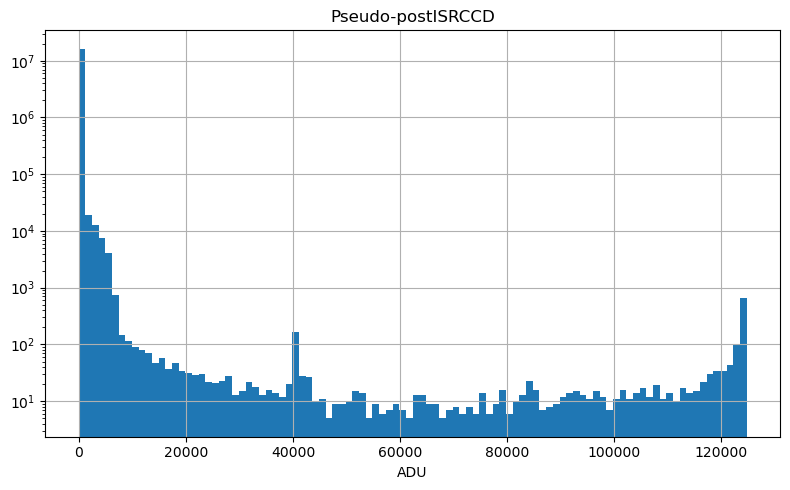

In [39]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
_ = ax.hist(test_.flatten(),bins=100)
ax.set_yscale("log")
ax.grid()
ax.set_xlabel('ADU')
ax.set_title('Pseudo-postISRCCD')
plt.tight_layout()

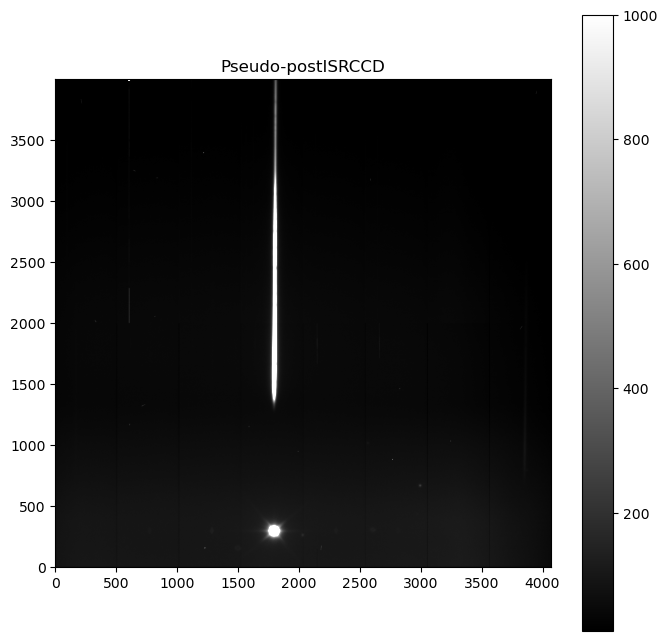

In [40]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(test_,cmap="gray",origin='lower',vmin=10,vmax=1000)
ax.set_title('Pseudo-postISRCCD')
fig.colorbar(im,ax=ax)

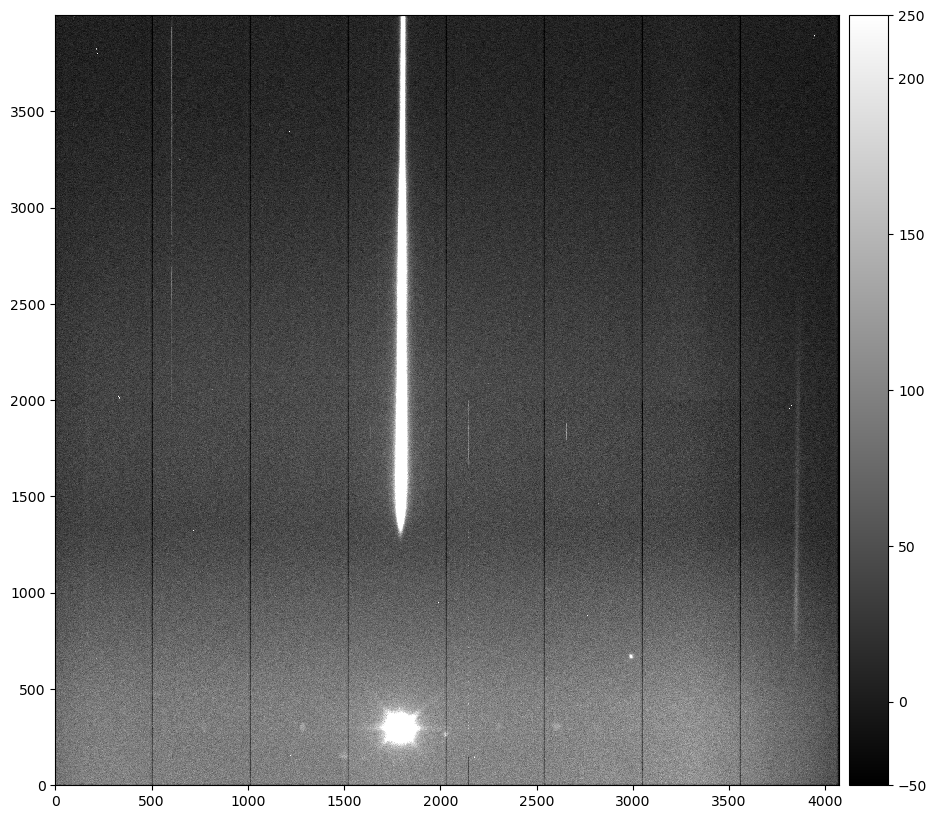

In [41]:
fig = plt.figure(figsize=(12,10))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('linear', 'zscale',None)
afw_display.mtv(isr_test.exposure.image)

# Sum up the individual exposures 

In [42]:
ids_selected = []
array_dict = {}
for i,id_ in enumerate(ids):
    print(id_)
    
    raw_img_ = butler.get('raw', dataId={'exposure': id_, 'instrument': 'LATISS', 'detector': 0}, collections = calibCollections)
    
    texp_ = raw_img_.getMetadata().toDict()['EXPTIME']
    
    metadata_isr = True
    if texp_==exp_time:
        bias_ = butler.get("bias",instrument=cameraName, exposure= id_, detector=0, collections=calibCollections)
        defects_ = butler.get('defects',instrument=cameraName, exposure= id_,detector=0,collections=calibCollections)

        #fast ISR 
        isr_img_ = isr_task.run(raw_img_,bias=bias_,defects=defects_)

        array_dict[id_] = isr_img_.exposure.image.array
        
        ids_selected.append(id_)
        
        if metadata_isr:
            md_isr = isr_img_.exposure.getMetadata().toDict()
            metadata_isr = False
        
        del(bias_)
        del(defects_)
        del(isr_img_)
    
    del(raw_img_)
ids_selected = np.array(ids_selected)

2023092600462


2023092600463


2023092600464


2023092600465


2023092600466


2023092600467


2023092600468


2023092600469


2023092600470


2023092600471


2023092600472


2023092600473


2023092600474


2023092600475


2023092600476


2023092600477


2023092600478


2023092600479


2023092600480


2023092600481


2023092600485
2023092600486


In [43]:
if len(ids_selected)<len(ids):
    print('{0} exposures were rejected for having texp < {1}'.format(len(ids)-len(ids_selected),exp_time))
else:
    print('All exposures were used')

2 exposures were rejected for having texp < 30.0


In [44]:
sum_array = np.zeros(array_dict[ids[0]].shape)

for id_ in ids_selected:
    sum_array = sum_array+array_dict[id_]

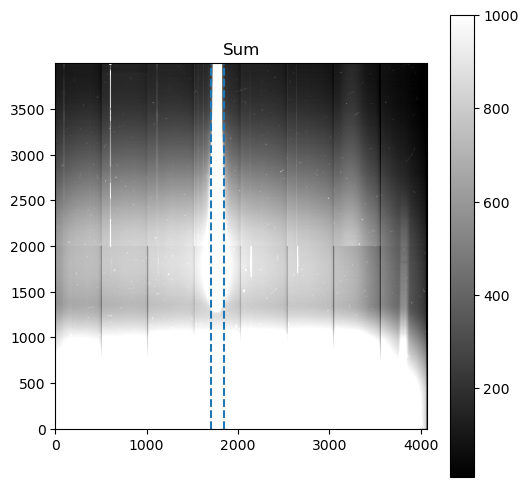

In [45]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(sum_array,cmap="gray",origin='lower',vmin=10,vmax=1000)
ax.axvline(x=1700,ls='--')
ax.axvline(x=1850,ls='--')
ax.set_title('Sum')
fig.colorbar(im,ax=ax)

Profile of a row from our amplifier of interest: 

Text(0, 0.5, 'Sum')

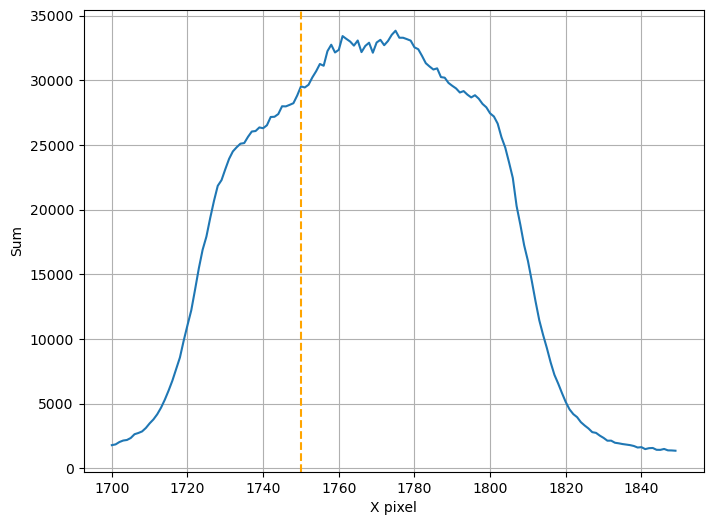

In [46]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(1700,1850),sum_array[1750,1700:1850])
ax.axvline(x=1750,ls='--',color='orange')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Sum')

# Detrending and flattening 

We do two different operations: 

* *Vertical:* we take the **mean** of each column to remove the signal differences due to the amplitude / intensity of the stellar spectrum. Since it is a vertical operation, we can take the full width of the amplifiers, but we need to take into account separately the upper and lower parts of the CCD, due the change in gain between amplifiers. We start with a global median, but we proceed with a local median by binning vertically. For the lower half of the CCD, we only compute from *yint00* up to the transition 

* *Horizontal:* we take the **median** of each row and we normalize by it in order to obtain a true flat. Since the horizontal shift only covers a small fraction of the amplifiers, we compute this median on a narrow pixel range on top of the shifted spectra, so we do not include the background. 


Select amplifiers: 

In [47]:
#Amplifier limits 
ampli0 = 'C03'
ampli1 = 'C13'
print(ampli_boxes[ampli0])
print(ampli_boxes[ampli1])
x0 = ampli_boxes[ampli0][0]
x1 = ampli_boxes[ampli0][1]
y00 = ampli_boxes[ampli0][2]
y01 = ampli_boxes[ampli0][3]
y11 = ampli_boxes[ampli1][3]

(1527, 2036, 0, 2000)
(1527, 2036, 2000, 4000)


Define regions: 

In [48]:
#Integration regions 
xint0 = 1750
xint1 = 1790
#xcenter = 1770
#xcenter = int(xint0+(xint1-xint0)/2.)
xcenter = int(np.mean(np.array([xint0,xint1])))

yint00 = 1390
yint01 = y01
yint1 = y11

In [49]:
int(np.mean(np.array([xint0,xint1]))), xcenter

(1770, 1770)

In [50]:
x0,xint0

(1527, 1750)

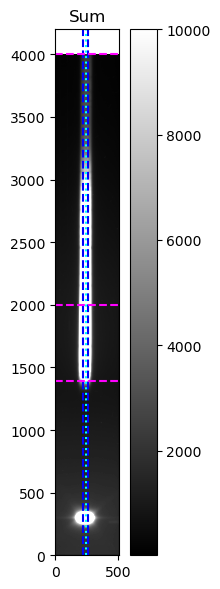

In [51]:
fig = plt.figure(figsize=(3,6))
ax = fig.add_subplot(111)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(sum_array[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=10,vmax=10000)
#ax.axvline(x=x0,ls='--',color='orange')
#ax.axvline(x=x1,ls='--',color='orange')
ax.axvline(x=xint0-x0,ls='--',color='b')
ax.axvline(x=xint1-x0,ls='--',color='b')
ax.axhline(y=yint00,ls='--',color='magenta')
ax.axhline(y=yint01,ls='--',color='magenta')
ax.axhline(y=yint1,ls='--',color='magenta')
ax.axvline(x=xcenter-x0,ls=':',color='cyan')
ax.set_title('Sum')
fig.colorbar(im,ax=ax)
plt.tight_layout()

### Y profile (spectrum) 

In [52]:
x_ampli = np.arange(x0,x1)
x_int = np.arange(xint0,xint1)
y_spec = np.arange(yint00,yint1)

In [53]:
spec_ = sum_array[yint00:yint1,xcenter]

Text(0, 0.5, 'ADU')

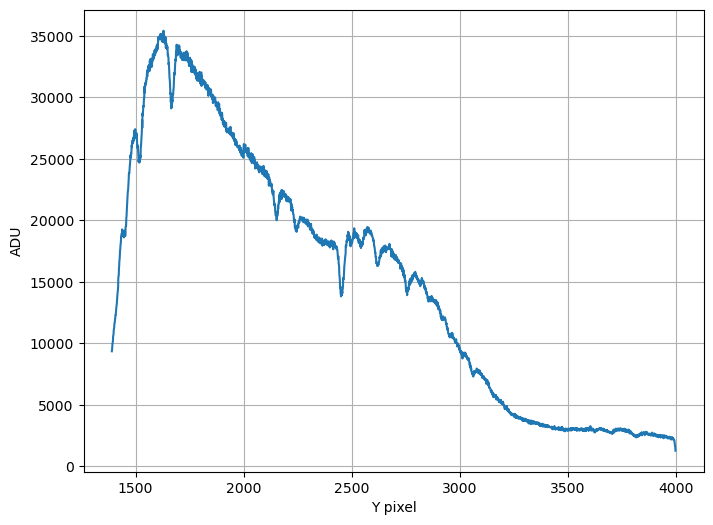

In [54]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(y_spec,spec_)
ax.grid()
#ax.set_xlim(1400,2000)
ax.set_xlabel('Y pixel')
ax.set_ylabel('ADU')

### X profile 

Text(0, 0.5, 'ADU')

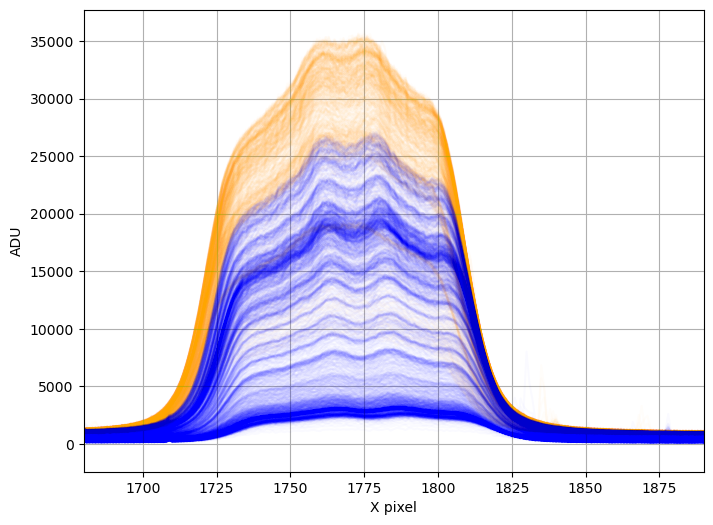

In [55]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for row_ in range(yint00,yint1):
    if row_<y01:
        color = 'orange'
    else:
        color = 'b'
    ax.plot(x_ampli,sum_array[row_,x0:x1],color=color,alpha=0.1/(i*0.2+1))
ax.set_xlim(1680,1890)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('ADU')

## Horizontal detrending: vertical operations 

Here we study the best option to perform the subtraction of the horizontal trend. This is produced by the different fluxes collected at each column of the CCD due to the seeing and the separation in pixels between each exposure along the x axis 

### Vertical global median 

In [56]:
median_down = np.median(sum_array[yint00:yint01,x0:x1],axis=0)
median_up = np.median(sum_array[yint01:yint1,x0:x1],axis=0)
print(median_down.shape)
print(median_up.shape)
median_global = np.mean(np.array([median_down,median_up]),axis=0)
print(median_global.shape)

(509,)
(509,)
(509,)


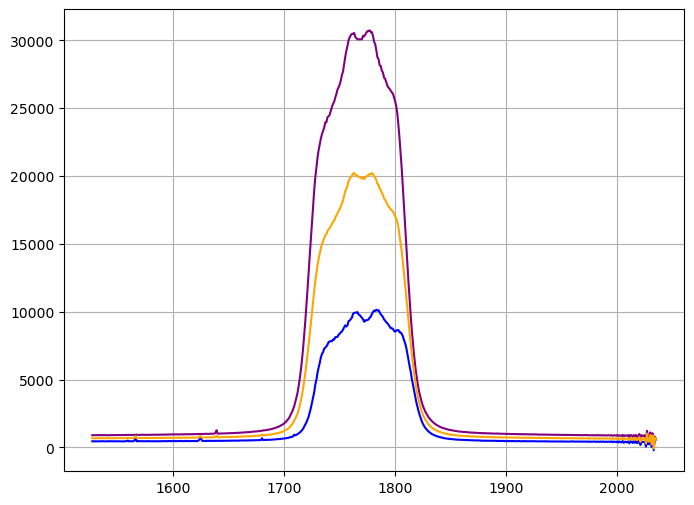

In [57]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(x_ampli,median_up,color='b')
ax.plot(x_ampli,median_down,color='purple')
ax.plot(x_ampli,median_global,color='orange')
ax.grid()

Text(0, 0.5, 'ADU/$\\langle \\mathrm{median} \\rangle$')

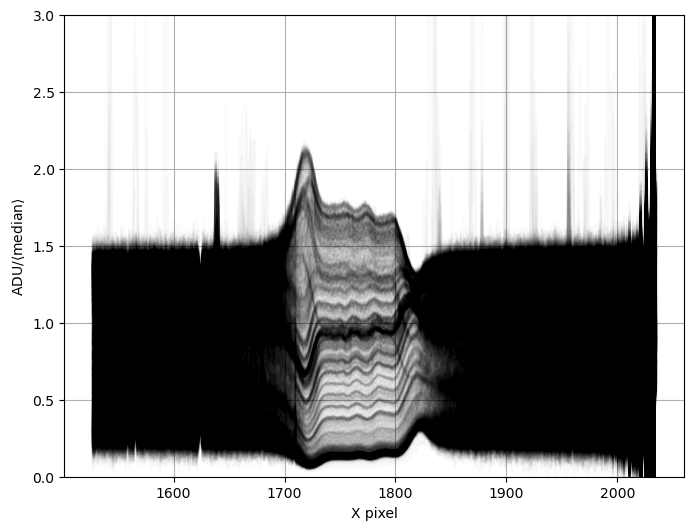

In [58]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for row_ in range(yint00,yint1):
    ax.plot(x_ampli,sum_array[row_,x0:x1]/median_global,color='k',alpha=0.1/(i*0.2+1))
#ax.set_xlim(1650,1800)
ax.set_ylim(0.,3.)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel(r'ADU/$\langle \mathrm{median} \rangle$')

### Vertical local mean with outlier rejection 

We need to make sure that the transition between lower and upper half at y = 2000 is contain within the list of bin edges 

In [59]:
binsize = 250

In [60]:
#bins_down = list(np.arange(yint00,yint01+1,binsize).astype('int'))
bins_down = [yint00,1700,yint01]
print(bins_down)
bins_up = list(np.arange(yint01,yint1+1,binsize).astype('int'))
print(bins_up)
bins = np.unique(np.array(bins_down+bins_up)).astype('int')
print(bins)

[1390, 1700, 2000]
[2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000]
[1390 1700 2000 2250 2500 2750 3000 3250 3500 3750 4000]


In [61]:
percentile = 1.

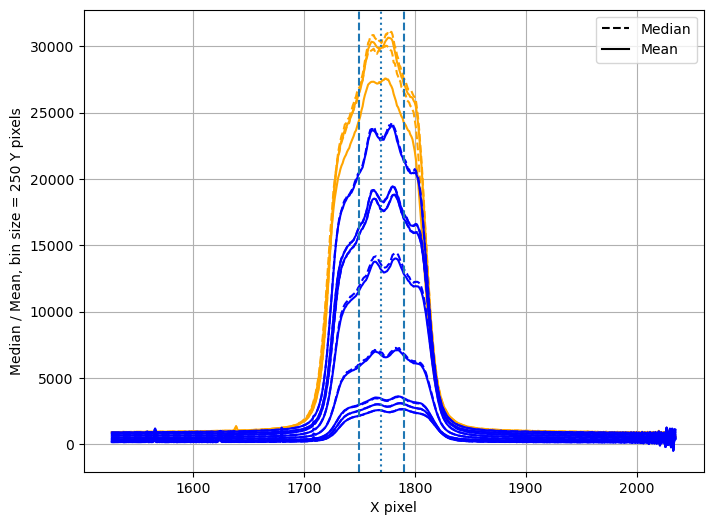

In [62]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
bins_median = {}
bins_mean = {}
for i in range(len(bins)-1):
    ibin0 = bins[i]
    ibin1 = bins[i+1]
    
    bin_median_ = np.median(sum_array[ibin0:ibin1,x0:x1],axis=0)
    
    bin_mean_ = []
    for col_ in range(x0,x1):
        #print(col_,len(sum_array[ibin0:ibin1,col_]))
        per0_ = np.percentile(sum_array[ibin0:ibin1,col_],percentile)
        per1_ = np.percentile(sum_array[ibin0:ibin1,col_],100.-percentile)
        per_mask_ = (sum_array[ibin0:ibin1,col_]>per0_)*(sum_array[ibin0:ibin1,col_]<per1_)
        bin_mean_.append(np.mean(sum_array[ibin0:ibin1,col_][per_mask_]))
    
    if ibin0<y01:
        color = 'orange'
    else:
        color = 'b'
    ax.plot(x_ampli,bin_median_,ls='--',color=color,alpha=1.0)
    ax.plot(x_ampli,bin_mean_,ls='-',color=color,alpha=1.0)
    bins_median[i+1] = bin_median_
    bins_mean[i+1] = bin_mean_
    
ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.plot([],[],ls='--',color='k',alpha=1.0,label='Median')
ax.plot([],[],ls='-',color='k',alpha=1.0,label='Mean')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Median / Mean, bin size = {0} Y pixels'.format(binsize))
ax.legend(loc="best")

## Now we compute the same but using a finer binning  

In [63]:
binsize_trend = 20

In [64]:
bins_down_trend = list(np.arange(yint00,yint01+1,binsize_trend).astype('int'))
#print(bins_down_trend)
bins_up_trend = list(np.arange(yint01,yint1+1,binsize_trend).astype('int'))
#print(bins_up_trend)
bins_trend = np.unique(np.array(bins_down_trend+bins_up_trend)).astype('int')
print(bins_trend)

[1390 1410 1430 1450 1470 1490 1510 1530 1550 1570 1590 1610 1630 1650
 1670 1690 1710 1730 1750 1770 1790 1810 1830 1850 1870 1890 1910 1930
 1950 1970 1990 2000 2020 2040 2060 2080 2100 2120 2140 2160 2180 2200
 2220 2240 2260 2280 2300 2320 2340 2360 2380 2400 2420 2440 2460 2480
 2500 2520 2540 2560 2580 2600 2620 2640 2660 2680 2700 2720 2740 2760
 2780 2800 2820 2840 2860 2880 2900 2920 2940 2960 2980 3000 3020 3040
 3060 3080 3100 3120 3140 3160 3180 3200 3220 3240 3260 3280 3300 3320
 3340 3360 3380 3400 3420 3440 3460 3480 3500 3520 3540 3560 3580 3600
 3620 3640 3660 3680 3700 3720 3740 3760 3780 3800 3820 3840 3860 3880
 3900 3920 3940 3960 3980 4000]


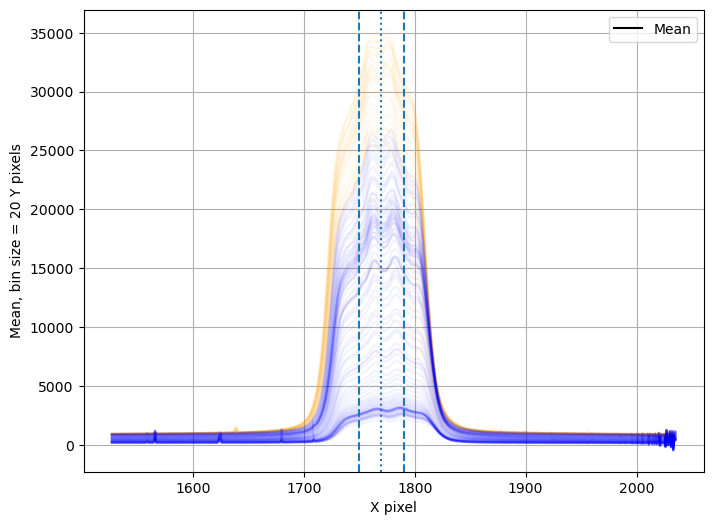

In [65]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
#bins_median = {}
bins_mean_trend_ = {}
for i in range(len(bins_trend)-1):
    ibin0 = bins_trend[i]
    ibin1 = bins_trend[i+1]
    
    #bin_median_ = np.median(sum_array[ibin0:ibin1,x0:x1],axis=0)
    
    bin_mean_ = []
    for col_ in range(x0,x1):
        #print(col_,len(sum_array[ibin0:ibin1,col_]))
        per0_ = np.percentile(sum_array[ibin0:ibin1,col_],percentile)
        per1_ = np.percentile(sum_array[ibin0:ibin1,col_],100.-percentile)
        per_mask_ = (sum_array[ibin0:ibin1,col_]>per0_)*(sum_array[ibin0:ibin1,col_]<per1_)
        bin_mean_.append(np.mean(sum_array[ibin0:ibin1,col_][per_mask_],axis=0))
    
    if ibin0<y01:
        color = 'orange'
    else:
        color = 'b'
    #ax.plot(x_ampli,bin_median_,ls='--',color=color,alpha=1.0)
    ax.plot(x_ampli,bin_mean_,ls='-',color=color,alpha=0.05)
    
    #bins_median[i+1] = np.array(bin_median_)
    bins_mean_trend_[i] = np.array(bin_mean_)
    

ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
#ax.plot([],[],ls='--',color='k',alpha=1.0,label='Median')
ax.plot([],[],ls='-',color='k',alpha=1.0,label='Mean')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))
ax.legend(loc="best")


### We subtract the sky background 

In [66]:
from scipy.optimize import curve_fit

In [67]:
def fun_bckg(x,a,b):
    return a*x+b

In [68]:
xbckg0 = 1660
xbckg1 = 1880

In [69]:
bins_mean_trend_.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130])

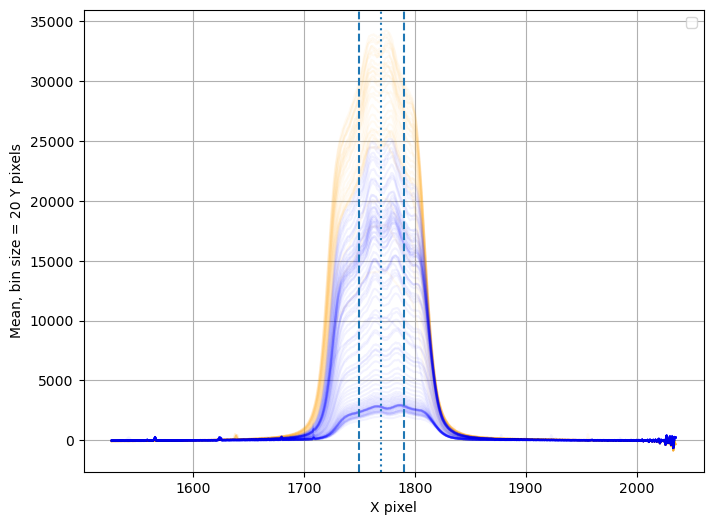

In [70]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

bins_mean_trend_nobckg_ = {}
#bins_coords = {}
for ibin in bins_mean_trend_.keys():
    
    if bins_trend[ibin-1]<y01:
        color = 'orange'
    else:
        color = 'b'
    
    bckg_mask = (x_ampli<xbckg0)+(x_ampli>xbckg1)
    bckg_ = bins_mean_trend_[ibin][bckg_mask]
    
    fit_params_,_ = curve_fit(fun_bckg,x_ampli[bckg_mask],bckg_)
    bckg_fit = fun_bckg(x_ampli,fit_params_[0],fit_params_[1])
    
    data_ = bins_mean_trend_[ibin]-bckg_fit
    ax.plot(x_ampli,data_,ls='-',color=color,alpha=0.05)
    bins_mean_trend_nobckg_[ibin] = data_
    #bins_coords[ibin] = (np.arange(x0,x1)[data_==np.max(data_)][0],
    #                    int((bins_trend[ibin-1]+bins_trend[ibin])/2),np.max(data_))

ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))
ax.legend(loc="best")

### We normalize each row (minus background) by the maximum value 

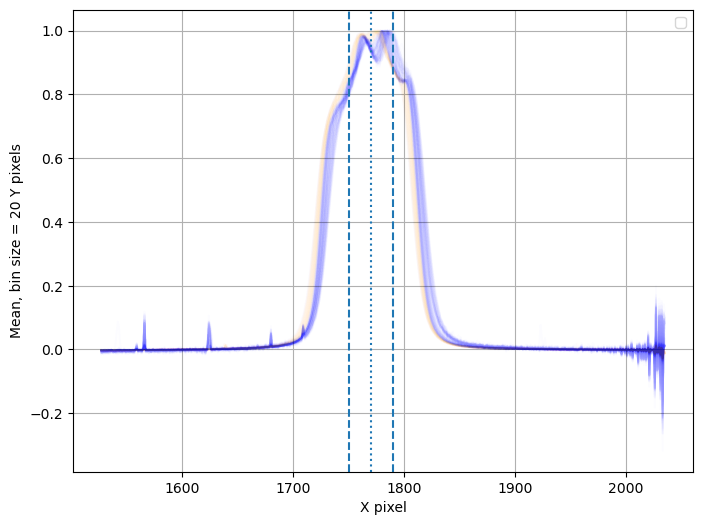

In [71]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

bins_mean_trend_norm_ = {}
bins_coords = {}
for ibin in bins_mean_trend_.keys():
    
    if bins_trend[ibin-1]<y01:
        color = 'orange'
    else:
        color = 'b'
    
    data_ = bins_mean_trend_nobckg_[ibin]/np.max(bins_mean_trend_nobckg_[ibin])
    ax.plot(x_ampli,data_,ls='-',color=color,alpha=0.01)
    bins_mean_trend_norm_[ibin] = data_
    bins_coords[ibin] = (np.arange(x0,x1)[data_==np.max(data_)][0],
                        int((bins_trend[ibin]+bins_trend[ibin+1])/2),np.max(data_))

ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))
ax.legend(loc="best")

### We fit the x coordinate of the maxima as a function of the y coordinate 

In [72]:
def fun_trend(x,a,b,c):
    return a*x**2.+b*x+c

def fun_trend3(x,a,b,c,d):
    return a*x**3.+b*x**2.+c*x+d

def fun_trend4(x,a,b,c,d,e):
    return a*x**4-b*x**3.+c*x**2.+d*x+e

In [73]:
x_max = []
y_max = []
for ibin in bins_coords.keys():
    x_max.append(bins_coords[ibin][0])
    y_max.append(bins_coords[ibin][1])
x_max = np.array(x_max)
y_max = np.array(y_max)

Text(0, 0.5, 'Y pixel')

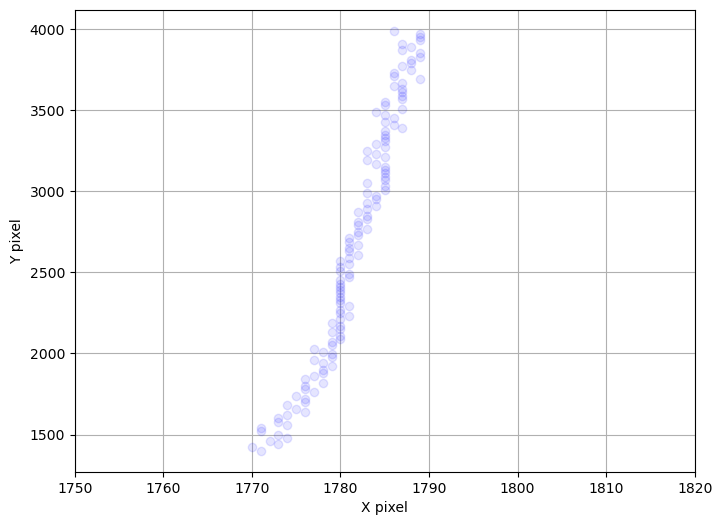

In [74]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(x_max,y_max,ls='',marker='o',color='b',alpha=0.1)
#ax.set_ylim(x0,x1)
ax.set_xlim(1750,1820)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')

In [75]:
trend_params,trend_cov = curve_fit(fun_trend,y_max,x_max)
trend_params3,trend_cov3 = curve_fit(fun_trend3,y_max,x_max)
trend_params4,trend_cov4 = curve_fit(fun_trend4,y_max,x_max)

In [76]:
trend_params,trend_params3, trend_params4

(array([-1.21046962e-06,  1.24114558e-02,  1.75754146e+03]),
 array([ 1.36273826e-09, -1.22276260e-05,  4.07112256e-02,  1.73461517e+03]),
 array([-1.27785083e-12, -1.51343500e-08, -6.60195521e-05,  1.30633931e-01,
         1.68049191e+03]))

In [77]:
x_fit = fun_trend(y_max,trend_params[0],trend_params[1],trend_params[2]).astype('int')
x_fit3 = fun_trend3(y_max,trend_params3[0],trend_params3[1],trend_params3[2],trend_params3[3]).astype('int')
x_fit4 = fun_trend4(y_max,trend_params4[0],trend_params4[1],trend_params4[2],trend_params4[3],trend_params4[4]).astype('int')

In [78]:
ref_bin = np.digitize(np.arange(yint00,yint1)[spec_==np.max(spec_)],bins_trend)[0]
print(ref_bin)
x_ref = x_max[ref_bin]
y_ref = y_max[ref_bin]
print(x_ref,y_ref)

12
1776 1640


Text(0, 0.5, 'Y pixel')

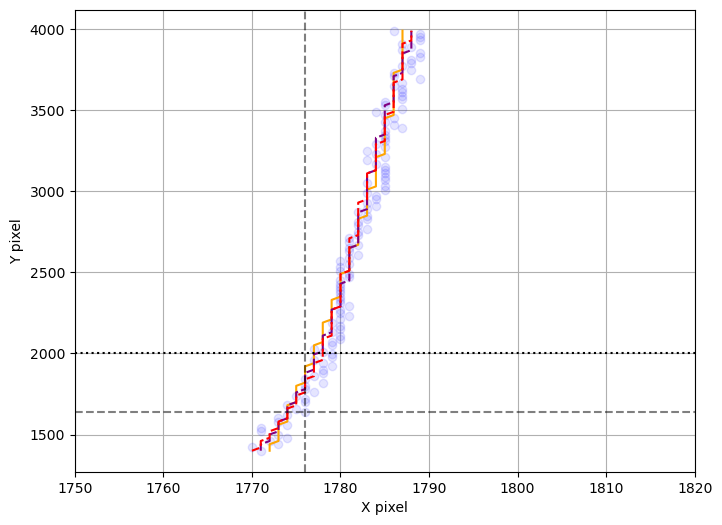

In [79]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(x_max,y_max,ls='',marker='o',color='b',alpha=0.1)
ax.plot(x_fit,y_max,ls='-',marker='',color='orange')
ax.plot(x_fit3,y_max,ls='--',marker='',color='purple')
ax.plot(x_fit4,y_max,ls='--',marker='',color='r')
ax.axvline(x=x_ref,ls='--',color='k',alpha=0.5)
ax.axhline(y=y_ref,ls='--',color='k',alpha=0.5)
ax.axhline(y=2000,ls=':',color='k')
#ax.set_ylim(x0,x1)
ax.set_xlim(1750,1820)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')

Text(0, 0.5, 'Y pixel')

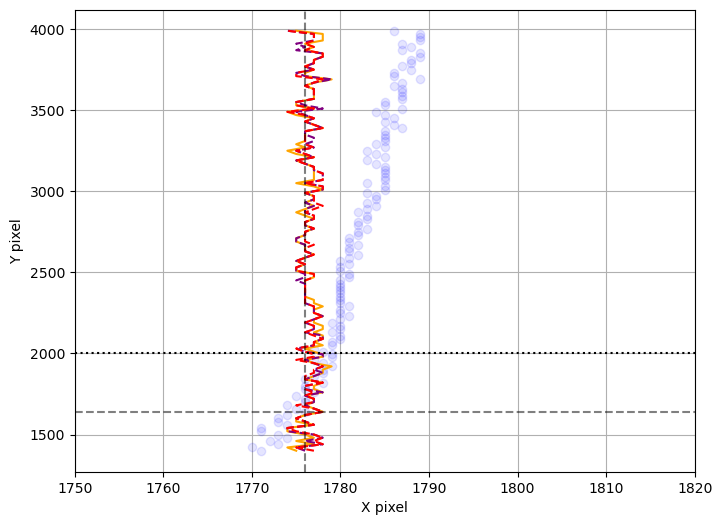

In [80]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(x_max,y_max,ls='',marker='o',color='b',alpha=0.1)
ax.plot(x_max+x_ref-x_fit,y_max,ls='-',marker='',color='orange')
ax.plot(x_max+x_ref-x_fit3,y_max,ls='--',marker='',color='purple')
ax.plot(x_max+x_ref-x_fit4,y_max,ls='--',marker='',color='r')
ax.axvline(x=x_ref,ls='--',color='k',alpha=0.5)
ax.axhline(y=y_ref,ls='--',color='k',alpha=0.5)
ax.axhline(y=2000,ls=':',color='k')
#ax.set_ylim(x0,x1)
ax.set_xlim(1750,1820)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')

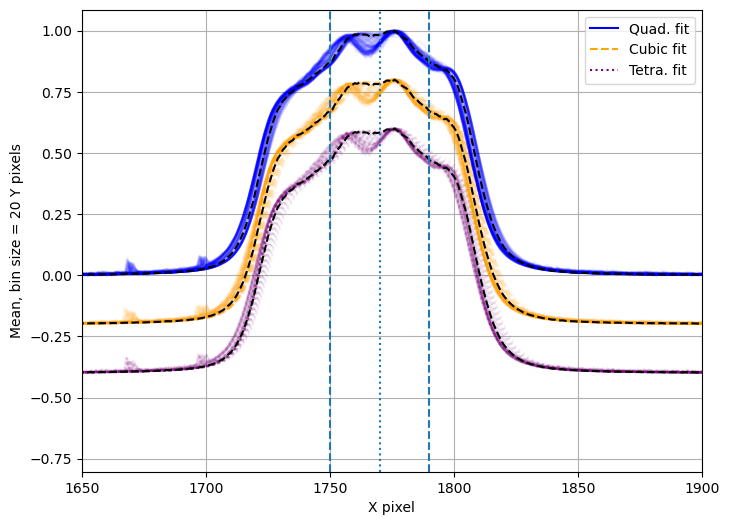

In [153]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for ibin in list(bins_mean_trend_.keys()):
    
    x_fit_ = fun_trend(y_max[ibin],trend_params[0],trend_params[1],trend_params[2])
    x_fit3_ = fun_trend3(y_max[ibin],trend_params3[0],trend_params3[1],trend_params3[2],trend_params3[3])
    x_fit4_ = fun_trend4(y_max[ibin],trend_params4[0],trend_params4[1],trend_params4[2],trend_params4[3],trend_params4[4])
    delta_ = x_ref-x_fit_
    delta3_ = x_ref-x_fit3_
    delta4_ = x_ref-x_fit4_
    ax.plot(x_ampli+delta_,bins_mean_trend_norm_[ibin],ls='-',color='b',alpha=0.05)
    ax.plot(x_ampli+delta3_,bins_mean_trend_norm_[ibin]-0.2,ls='--',color='orange',alpha=0.05)
    ax.plot(x_ampli+delta4_,bins_mean_trend_norm_[ibin]-0.4,ls=':',color='purple',alpha=0.05)
    #ax.plot(x_ampli,bins_mean_trend_norm[ibin],ls=':',color=color,alpha=0.03)
    
ax.plot(x_ampli,bins_mean_trend_norm_[ref_bin],ls='--',color='k')
ax.plot(x_ampli,bins_mean_trend_norm_[ref_bin]-0.2,ls='--',color='k')
ax.plot(x_ampli,bins_mean_trend_norm_[ref_bin]-0.4,ls='--',color='k')
ax.plot([],[],ls='-',color='b',label='Quad. fit')
ax.plot([],[],ls='--',color='orange',label='Cubic fit')
ax.plot([],[],ls=':',color='purple',label='Tetra. fit')
ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.set_xlim(1650,1900)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))
ax.legend(loc="best")


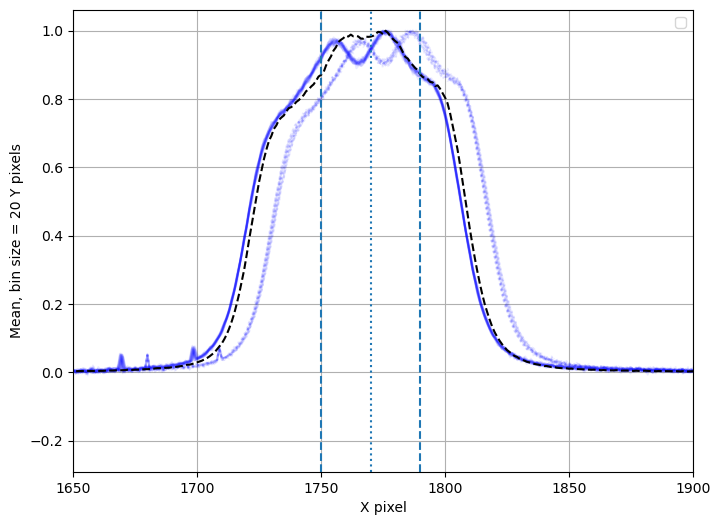

In [82]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

for ibin in list(bins_mean_trend_.keys())[100:120]:
    
    if bins_trend[ibin-1]<y01:
        color = 'orange'
        alpha = 0.07
    else:
        color = 'b'
        alpha = 0.08
    
    x_fit_ = fun_trend(y_max[ibin],trend_params[0],trend_params[1],trend_params[2])
    x_fit3_ = fun_trend3(y_max[ibin],trend_params3[0],trend_params3[1],trend_params3[2],trend_params3[3])
    x_fit4_ = fun_trend4(y_max[ibin],trend_params4[0],trend_params4[1],trend_params4[2],trend_params4[3],trend_params4[4])
    delta_ = x_ref-x_fit_
    delta3_ = x_ref-x_fit3_
    delta4_ = x_ref-x_fit4_
    ax.plot(x_ampli+delta_,bins_mean_trend_norm_[ibin],ls='-',color=color,alpha=alpha)
    #ax.plot(x_ampli+delta3_,bins_mean_trend_norm_[ibin],ls='--',color=color,alpha=alpha)
    #ax.plot(x_ampli+delta4_,bins_mean_trend_norm_[ibin],ls='-.',color=color,alpha=alpha)
    ax.plot(x_ampli,bins_mean_trend_norm_[ibin],ls=':',color=color,alpha=0.08)
    
ax.plot(x_ampli,bins_mean_trend_norm_[ref_bin],ls='--',color='k')
ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.set_xlim(1650,1900)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))
ax.legend(loc="best")


In [83]:
y_spec,yint00,yint1

(array([1390, 1391, 1392, ..., 3997, 3998, 3999]), 1390, 4000)

## Now, let us run the whole process 

- 1 - Shift in x according to fit 
- 2 - Vertical projection 
- 3 - Vertical trend subtraction 
- 4 - Return to original x position 

Note that the fit was obtained from the image that 

- was vertically binned; 
- had the background subtracted; 
- was normalized by the maximum in each bin. 

Then, in order to deproject (i.e., project + subtract) along the x trend that we have determined, we need to do it on an image that undergoes the same process. We do this between steps 1 and 2  

### 1 - Shift in x 

This is done on the sum image 

Text(0, 0.5, 'Y pixel')

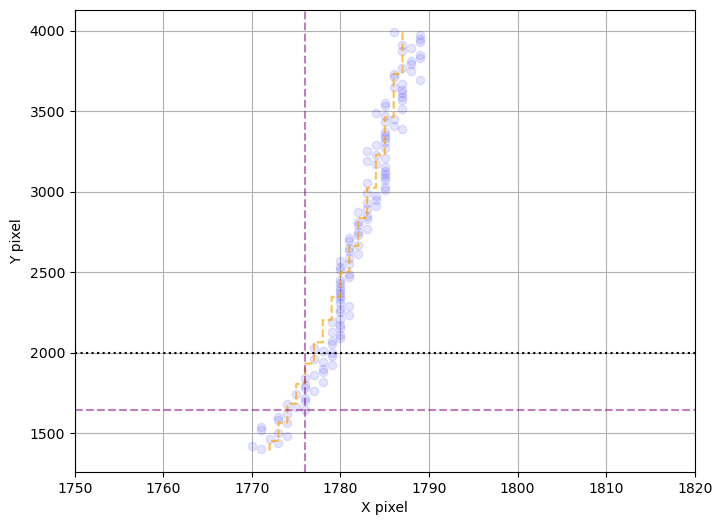

In [84]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(x_max,y_max,ls='',marker='o',color='b',alpha=0.1)
x_fit_all = fun_trend(y_spec,trend_params[0],trend_params[1],trend_params[2]).astype('int')
ax.plot(x_fit_all,y_spec,ls='--',marker='',color='orange',alpha=0.7)
ax.axvline(x=x_ref,ls='--',color='purple',alpha=0.5)
ax.axhline(y=y_ref,ls='--',color='purple',alpha=0.5)
ax.axhline(y=2000,ls=':',color='k')
#ax.set_ylim(x0,x1)
ax.set_xlim(1750,1820)
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Y pixel')

In [85]:
nvalidrow = yint1-yint00
ncol = sum_array.shape[1]
print(nvalidrow,ncol)

2610 4072


In [86]:
delta_x = x_ref-x_fit

In [87]:
delta_x

array([  4,   4,   4,   3,   3,   3,   3,   3,   3,   2,   2,   2,   2,
         2,   2,   1,   1,   1,   1,   1,   1,   0,   0,   0,   0,   0,
         0,  -1,  -1,  -1,  -1,  -1,  -1,  -1,  -2,  -2,  -2,  -2,  -2,
        -2,  -2,  -3,  -3,  -3,  -3,  -3,  -3,  -3,  -4,  -4,  -4,  -4,
        -4,  -4,  -4,  -4,  -5,  -5,  -5,  -5,  -5,  -5,  -5,  -5,  -6,
        -6,  -6,  -6,  -6,  -6,  -6,  -6,  -6,  -7,  -7,  -7,  -7,  -7,
        -7,  -7,  -7,  -7,  -8,  -8,  -8,  -8,  -8,  -8,  -8,  -8,  -8,
        -8,  -9,  -9,  -9,  -9,  -9,  -9,  -9,  -9,  -9,  -9,  -9,  -9,
       -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10, -10,
       -10, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11, -11,
       -11])

In [88]:
len(delta_x)

131

In [89]:
bins_trend

array([1390, 1410, 1430, 1450, 1470, 1490, 1510, 1530, 1550, 1570, 1590,
       1610, 1630, 1650, 1670, 1690, 1710, 1730, 1750, 1770, 1790, 1810,
       1830, 1850, 1870, 1890, 1910, 1930, 1950, 1970, 1990, 2000, 2020,
       2040, 2060, 2080, 2100, 2120, 2140, 2160, 2180, 2200, 2220, 2240,
       2260, 2280, 2300, 2320, 2340, 2360, 2380, 2400, 2420, 2440, 2460,
       2480, 2500, 2520, 2540, 2560, 2580, 2600, 2620, 2640, 2660, 2680,
       2700, 2720, 2740, 2760, 2780, 2800, 2820, 2840, 2860, 2880, 2900,
       2920, 2940, 2960, 2980, 3000, 3020, 3040, 3060, 3080, 3100, 3120,
       3140, 3160, 3180, 3200, 3220, 3240, 3260, 3280, 3300, 3320, 3340,
       3360, 3380, 3400, 3420, 3440, 3460, 3480, 3500, 3520, 3540, 3560,
       3580, 3600, 3620, 3640, 3660, 3680, 3700, 3720, 3740, 3760, 3780,
       3800, 3820, 3840, 3860, 3880, 3900, 3920, 3940, 3960, 3980, 4000])

In [93]:
bins_mean_trend_.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130])

In [94]:
np.digitize(yint00,bins_trend)

1

Create shifted array 

In [95]:
shifted_array = np.ones(sum_array.shape)

for row in range(yint00,yint1):
    
    row_bin_ = np.digitize(row,bins_trend)-1
    
    if delta_x[row_bin_]<=0:
        i_0 = 0
        i_f = ncol-np.abs(delta_x[row_bin_])
    else:
        i_0 = delta_x[row_bin_]
        i_f = ncol
    
    for i in range(i_0,i_f):
        shifted_array[row,i] = sum_array[row,i-delta_x[row_bin_]]


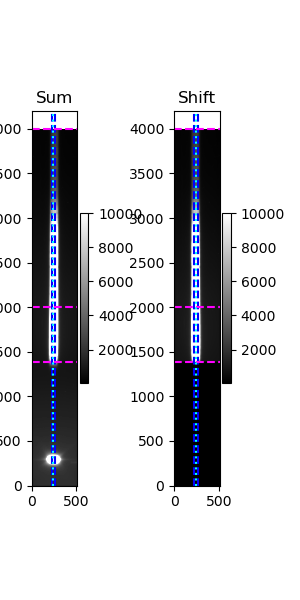

In [97]:
fig = plt.figure(figsize=(3,6))
ax = fig.add_subplot(121)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(sum_array[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=10,vmax=10000)
#ax.axvline(x=x0,ls='--',color='orange')
#ax.axvline(x=x1,ls='--',color='orange')
ax.axvline(x=xint0-x0,ls='--',color='b')
ax.axvline(x=xint1-x0,ls='--',color='b')
ax.axhline(y=yint00,ls='--',color='magenta')
ax.axhline(y=yint01,ls='--',color='magenta')
ax.axhline(y=yint1,ls='--',color='magenta')
ax.axvline(x=xcenter-x0,ls=':',color='cyan')
ax.set_title('Sum')
fig.colorbar(im,ax=ax)

ax = fig.add_subplot(122)
#im = ax.imshow(isr_test.exposure.image.array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(shifted_array[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=10,vmax=10000)
#ax.axvline(x=x0,ls='--',color='orange')
#ax.axvline(x=x1,ls='--',color='orange')
ax.axvline(x=xint0-x0,ls='--',color='b')
ax.axvline(x=xint1-x0,ls='--',color='b')
ax.axhline(y=yint00,ls='--',color='magenta')
ax.axhline(y=yint01,ls='--',color='magenta')
ax.axhline(y=yint1,ls='--',color='magenta')
ax.axvline(x=xcenter-x0,ls=':',color='cyan')
ax.set_title('Shift')
fig.colorbar(im,ax=ax)
plt.tight_layout()

### 2 - Vertical projection 

We need to redo the previous process on the shifted image, that is:  

- vertical bin; 
- background subtraction; 
- normalizing by the maximum. 



**Vertical binning** 

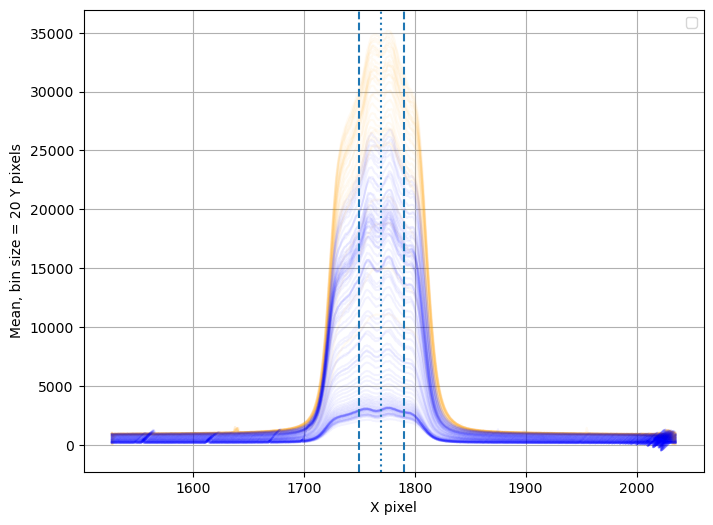

In [154]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
bins_mean_trend = {}
for i in range(len(bins_trend)-1):
    ibin0 = bins_trend[i]
    ibin1 = bins_trend[i+1]
    
    #bin_median_ = np.median(sum_array[ibin0:ibin1,x0:x1],axis=0)
    
    bin_mean_ = []
    for col_ in range(x0,x1):
        #print(col_,len(sum_array[ibin0:ibin1,col_]))
        per0_ = np.percentile(shifted_array[ibin0:ibin1,col_],percentile)
        per1_ = np.percentile(shifted_array[ibin0:ibin1,col_],100.-percentile)
        per_mask_ = (shifted_array[ibin0:ibin1,col_]>per0_)*(shifted_array[ibin0:ibin1,col_]<per1_)
        bin_mean_.append(np.mean(shifted_array[ibin0:ibin1,col_][per_mask_],axis=0))
    
    if ibin0<y01:
        color = 'orange'
    else:
        color = 'b'
    #ax.plot(x_ampli,bin_median_,ls='--',color=color,alpha=1.0)
    ax.plot(x_ampli,bin_mean_,ls='-',color=color,alpha=0.05)
    
    #bins_median[i+1] = np.array(bin_median_)
    bins_mean_trend[i] = np.array(bin_mean_)
    

ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))


**Background subtraction** 

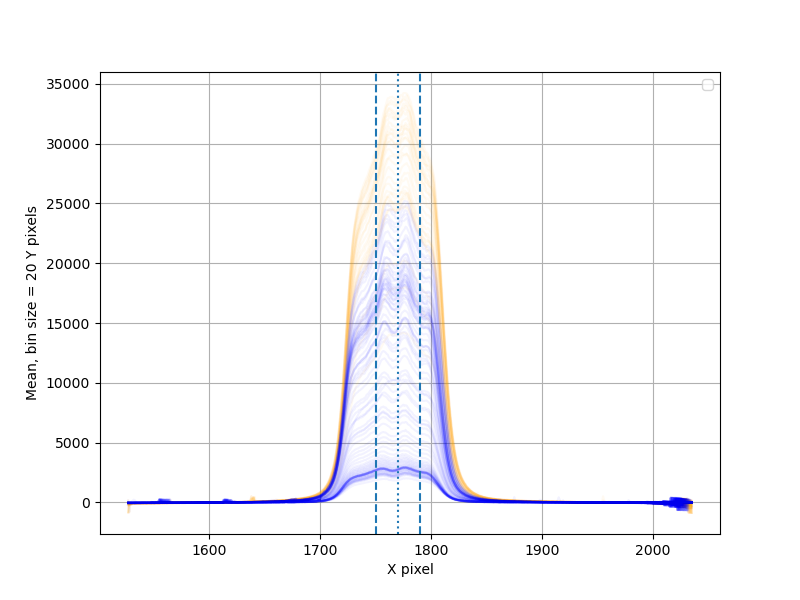

In [99]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

bins_mean_trend_nobckg = {}
#bins_coords = {}
for ibin in bins_mean_trend.keys():
    
    if bins_trend[ibin-1]<y01:
        color = 'orange'
    else:
        color = 'b'
    
    bckg_mask = (x_ampli<xbckg0)+(x_ampli>xbckg1)
    bckg_ = bins_mean_trend[ibin][bckg_mask]
    
    fit_params_,_ = curve_fit(fun_bckg,x_ampli[bckg_mask],bckg_)
    bckg_fit = fun_bckg(x_ampli,fit_params_[0],fit_params_[1])
    
    data_ = bins_mean_trend[ibin]-bckg_fit
    ax.plot(x_ampli,data_,ls='-',color=color,alpha=0.05)
    bins_mean_trend_nobckg[ibin] = data_
    #bins_coords[ibin] = (np.arange(x0,x1)[data_==np.max(data_)][0],
    #                    int((bins_trend[ibin-1]+bins_trend[ibin])/2),np.max(data_))

ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))


**Normalization by maximum** 

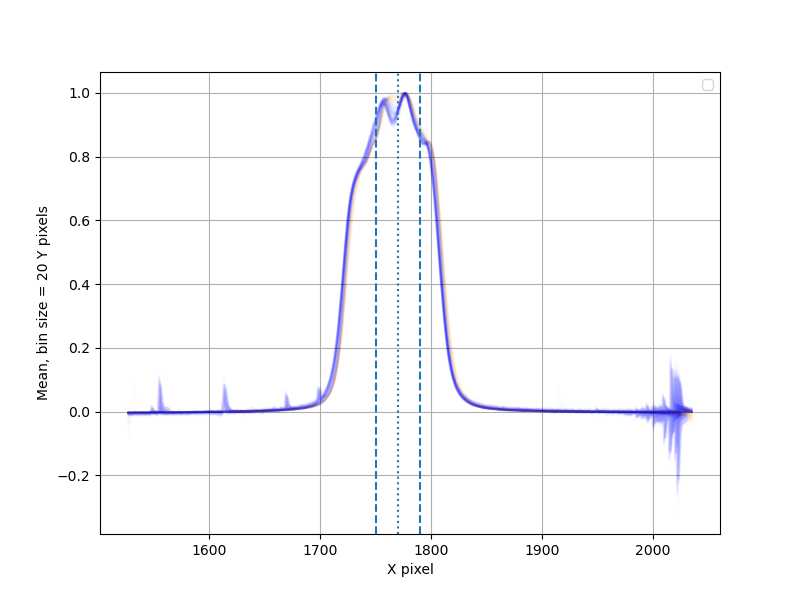

In [122]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

bins_mean_trend_norm = {}
for ibin in bins_mean_trend.keys():
    
    if bins_trend[ibin-1]<y01:
        color = 'orange'
    else:
        color = 'b'
    
    data_ = bins_mean_trend_nobckg[ibin]/np.max(bins_mean_trend_nobckg[ibin])
    ax.plot(x_ampli,data_,ls='-',color=color,alpha=0.01)
    bins_mean_trend_norm[ibin] = data_

ax.axvline(x=xint0,ls='--')
ax.axvline(x=xint1,ls='--')
ax.axvline(x=xcenter,ls=':')
ax.grid()
ax.set_xlabel('X pixel')
ax.set_ylabel('Mean, bin size = {0} Y pixels'.format(binsize_trend))


### 3 - Vertical trend subtraction 

In [129]:
detrended_array = np.ones(sum_array.shape)

for row in range(yint00,yint1):
    
    row_bin_ = np.digitize(row,bins_trend)-1
    bin_mean_ = bins_mean_trend_norm[row_bin_]
    
    detrended_array[row,x0:x1] = shifted_array[row,x0:x1]/bin_mean_

Text(0.5, 0, 'X pixel')

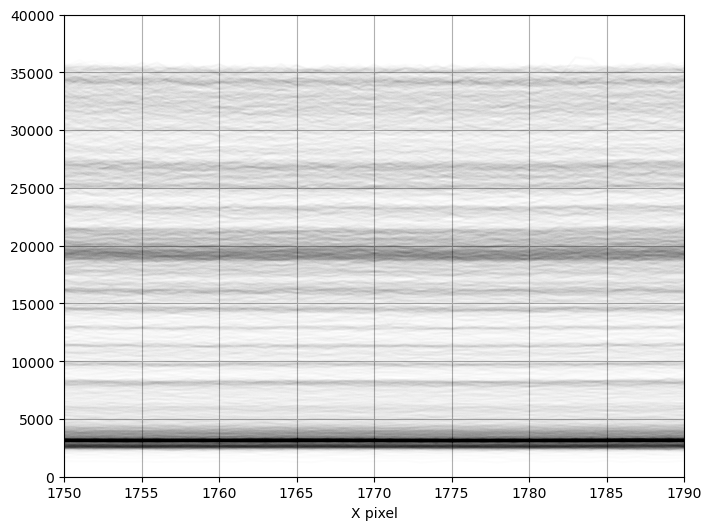

In [130]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
for row_ in range(yint00,yint1):
    ax.plot(np.arange(x0,x1),detrended_array[row_,x0:x1],color='k',alpha=0.01)
ax.set_xlim(xint0,xint1)
ax.set_ylim(0.,4e4)
ax.grid()
ax.set_xlabel('X pixel')
#ax.set_ylabel(r'ADU/$\langle \mathrm{median} \rangle$')

Text(0.5, 0, 'Y pixel')

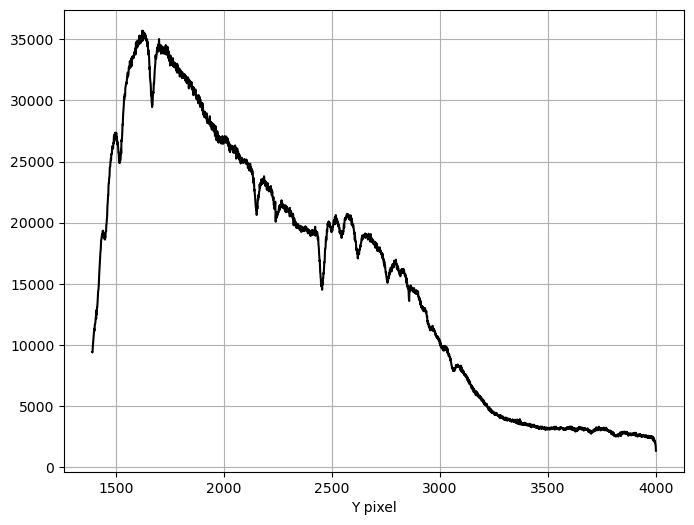

In [131]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(y_spec,detrended_array[yint00:yint1,xcenter],color='k',alpha=1)
#ax.set_xlim(xint0,xint1)
#ax.set_ylim(0.,4e4)
ax.grid()
ax.set_xlabel('Y pixel')

### 4 - Return to original position 

In [132]:
good_array = np.ones(sum_array.shape)

for row in range(yint00,yint1):
    #print(row)
    row_bin_ = np.digitize(row,bins_trend)-1
    
    if delta_x[row_bin_]<=0:
        i_0 = np.abs(delta_x[row_bin_])
        i_f = ncol
    else:
        i_0 = 0
        i_f = ncol-delta_x[row_bin_]
    
    for i in range(i_0,i_f):
        good_array[row,i] = detrended_array[row,i+delta_x[row_bin_]]


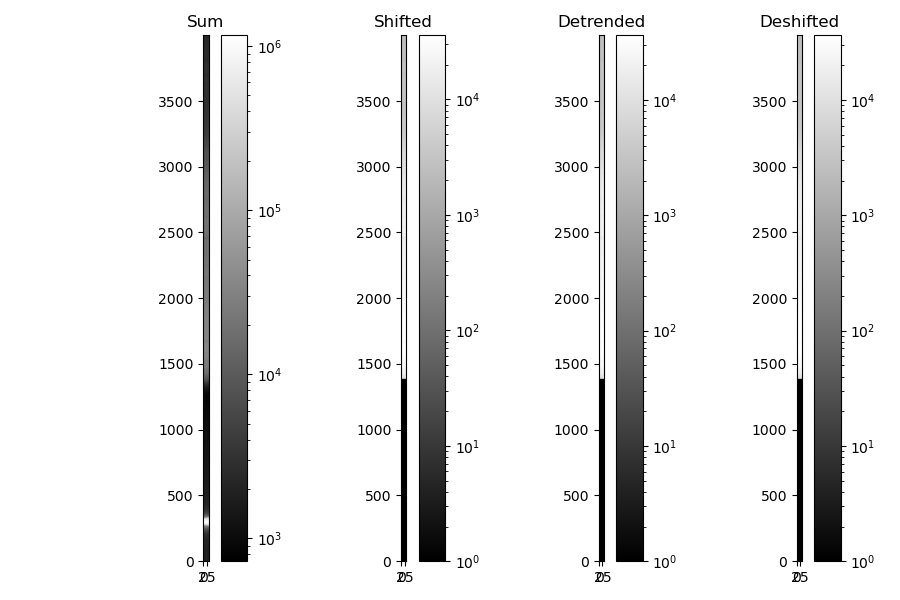

In [139]:
%matplotlib widget
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(141)
im = ax.imshow(sum_array[y00:y11,xint0:xint1],cmap="gray",origin='lower',norm=LogNorm())
#im = ax.imshow(sum_array[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=10,vmax=10000)
ax.set_title('Sum')
fig.colorbar(im,ax=ax)

ax = fig.add_subplot(142)
im = ax.imshow(shifted_array[y00:y11,xint0:xint1],cmap="gray",origin='lower',norm=LogNorm())
#im = ax.imshow(shifted_array[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=10,vmax=10000)
ax.set_title('Shifted')
fig.colorbar(im,ax=ax)

ax = fig.add_subplot(143)
im = ax.imshow(detrended_array[y00:y11,xint0:xint1],cmap="gray",origin='lower',norm=LogNorm())
#im = ax.imshow(good_array[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=1)#,vmax=10000)
ax.set_title('Detrended')
fig.colorbar(im,ax=ax)
plt.tight_layout()

ax = fig.add_subplot(144)
im = ax.imshow(good_array[y00:y11,xint0:xint1],cmap="gray",origin='lower',norm=LogNorm())
#im = ax.imshow(good_array[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=1)#,vmax=10000)
ax.set_title('Deshifted')
fig.colorbar(im,ax=ax)
plt.tight_layout()

Text(0.5, 0, 'Y pixel')

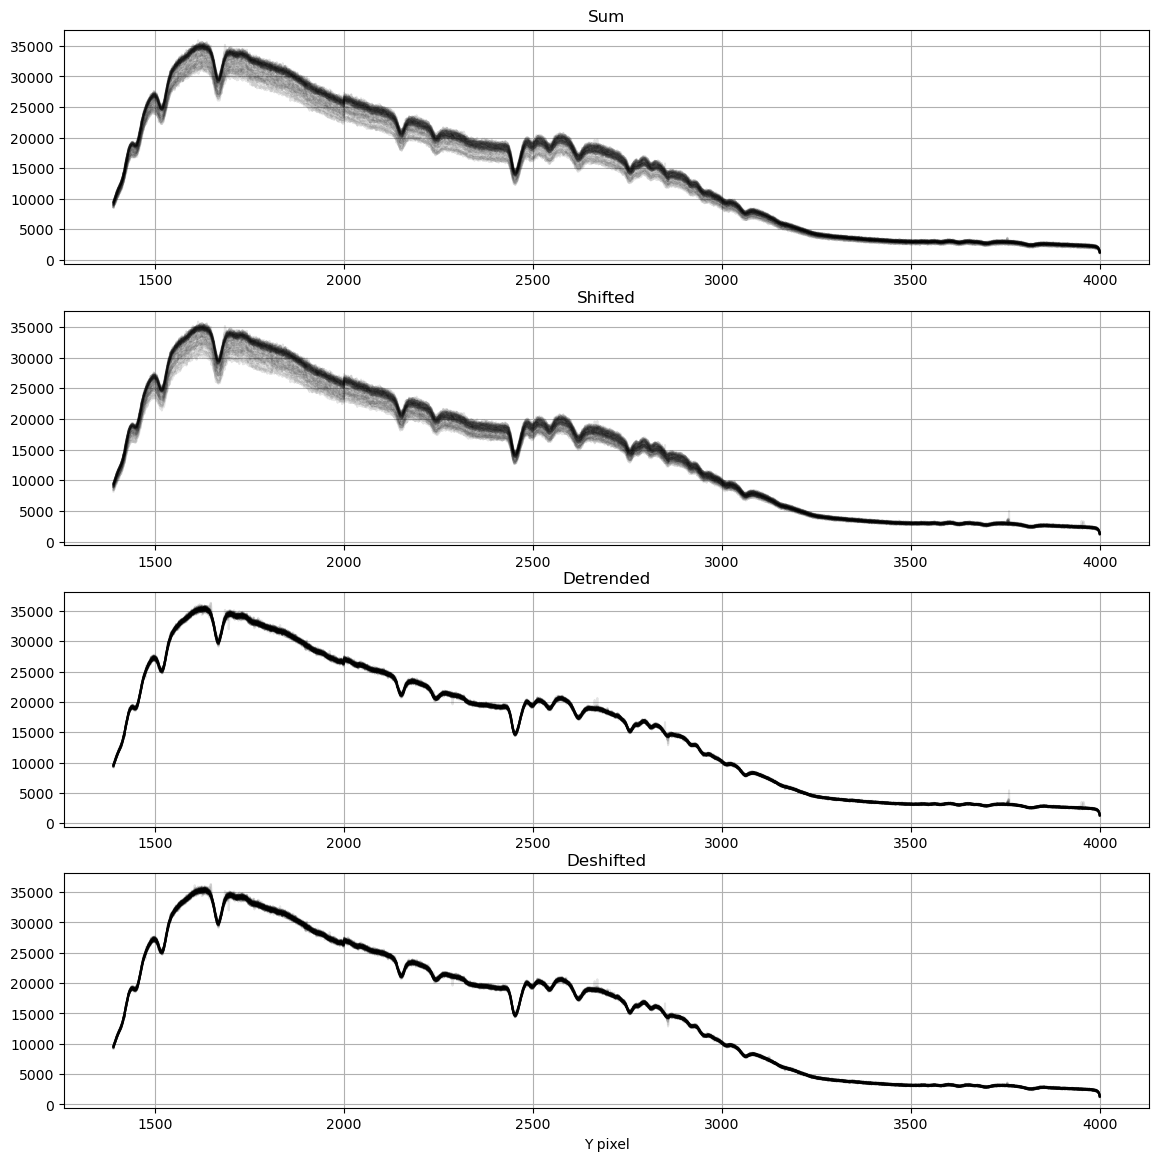

In [146]:
%matplotlib inline
fig = plt.figure(figsize=(14,14))
ax1 = fig.add_subplot(411)
ax2 = fig.add_subplot(412)
ax3 = fig.add_subplot(413)
ax4 = fig.add_subplot(414)

for col_ in range(xint0,xint1):
    ax1.plot(y_spec,sum_array[yint00:yint1,col_],color='k',alpha=0.1)
    ax2.plot(y_spec,shifted_array[yint00:yint1,col_],color='k',alpha=0.1)
    ax3.plot(y_spec,detrended_array[yint00:yint1,col_],color='k',alpha=0.1)
    ax4.plot(y_spec,good_array[yint00:yint1,col_],color='k',alpha=0.1)
    
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_title('Sum')
ax2.set_title('Shifted')
ax3.set_title('Detrended')
ax4.set_title('Deshifted')
ax4.set_xlabel('Y pixel')

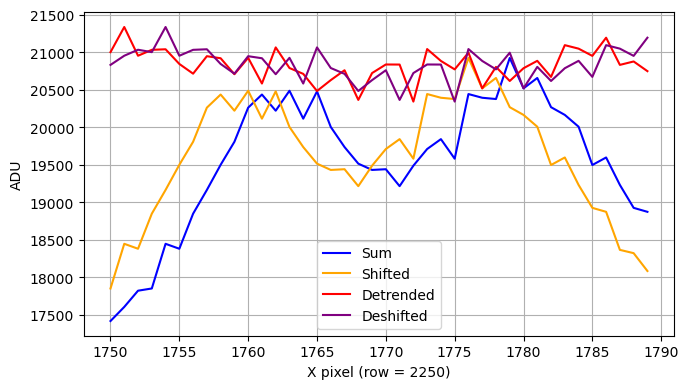

In [189]:
row_ = 2250
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111)
ax.plot(np.arange(xint0,xint1),sum_array[row_,xint0:xint1],color='b',label='Sum')
ax.plot(np.arange(xint0,xint1),shifted_array[row_,xint0:xint1],color='orange',label='Shifted')
ax.plot(np.arange(xint0,xint1),detrended_array[row_,xint0:xint1],color='r',label='Detrended')
ax.plot(np.arange(xint0,xint1),good_array[row_,xint0:xint1],color='purple',label='Deshifted')
ax.grid()
ax.set_xlabel('X pixel (row = {0})'.format(row_))
ax.set_ylabel('ADU')
ax.legend(loc="best")
plt.tight_layout()

# Creation of the flat image 

## Vertical detrending: horizontal operations 

Here we study the best option to perform the subtraction of the vertical trend. This is produced by the different fluxes collected at each row of the CCD as a function of the spectral properties of the target. It is also impacted by the seeing. In doing so, we are effectively generating the flat image  


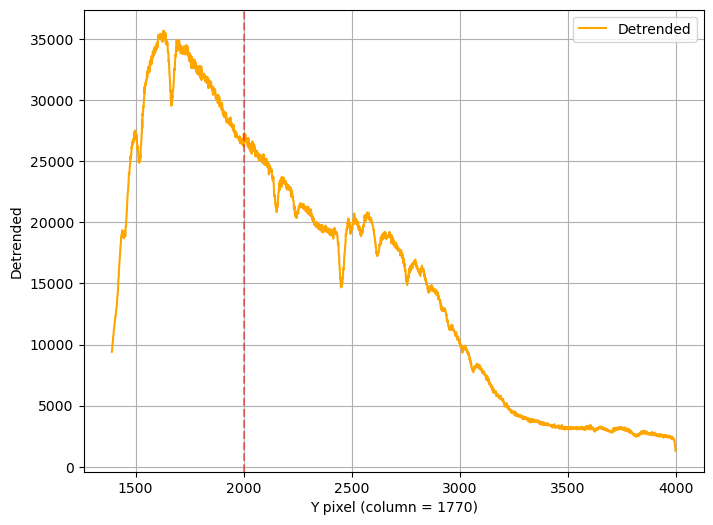

In [167]:
#norm_spec_y2 = detrend_array[yint00:yint1,xcenter]
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(y_spec,good_array[yint00:yint1,xcenter],color='orange',label='Detrended')
ax.axvline(x=2000,ls='--',color='r',alpha=0.5)
ax.grid()
ax.set_xlabel('Y pixel (column = {0})'.format(xcenter))
ax.set_ylabel('Detrended')
ax.legend(loc="best")

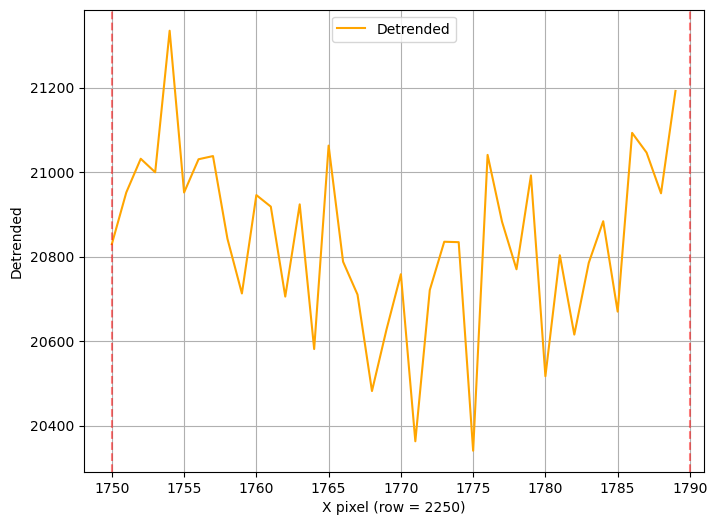

In [168]:
#norm_spec_x2 = detrend_array[1700,xint0:xint1]
row_ = 2250
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(xint0,xint1),good_array[row_,xint0:xint1],color='orange',label='Detrended')
ax.axvline(x=xint0,ls='--',color='r',alpha=0.5)
ax.axvline(x=xint1,ls='--',color='r',alpha=0.5)
ax.grid()
ax.set_xlabel('X pixel (row = {0})'.format(row_))
ax.set_ylabel('Detrended')
ax.legend(loc="best")

In [169]:
ylim0_ = 1500
ylim1_ = 1600

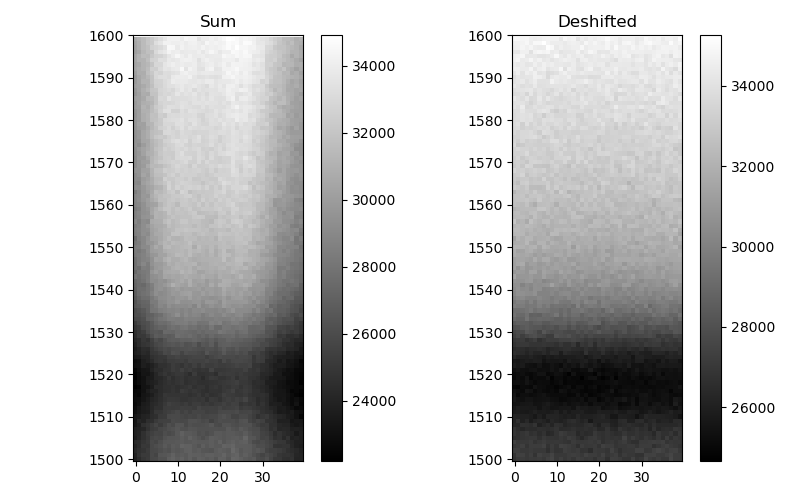

In [174]:
%matplotlib widget
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(121)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(sum_array[ylim0_:ylim1_,xint0:xint1],cmap="gray",origin='lower')#,vmin=0.99,vmax=1.01)
ax.set_title('Sum')
ax.set_yticks(np.linspace(ylim0_,ylim1_,11)-ylim0_,labels=np.linspace(ylim0_,ylim1_,11).astype('int'))
fig.colorbar(im,ax=ax)

ax = fig.add_subplot(122)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(good_array[ylim0_:ylim1_,xint0:xint1],cmap="gray",origin='lower')#,vmin=0.99,vmax=1.01)
ax.set_title('Deshifted')
ax.set_yticks(np.linspace(ylim0_,ylim1_,11)-ylim0_,labels=np.linspace(ylim0_,ylim1_,11).astype('int'))
fig.colorbar(im,ax=ax)

plt.tight_layout()

## Flatening 

In [175]:
row_median = np.median(good_array[yint00:yint1,xint0:xint1],axis=1)
row_mean = np.mean(good_array[yint00:yint1,xint0:xint1],axis=1)
print(row_median.shape)

(2610,)


In [180]:
flat_array_median = np.ones(sum_array.shape)
flat_array_mean = np.ones(sum_array.shape)
flat_array_median[yint00:yint1,xint0:xint1] = good_array[yint00:yint1,xint0:xint1]/row_median[:,None]
flat_array_mean[yint00:yint1,xint0:xint1] = good_array[yint00:yint1,xint0:xint1]/row_mean[:,None]
print(flat_array_median.shape)

(4000, 4072)


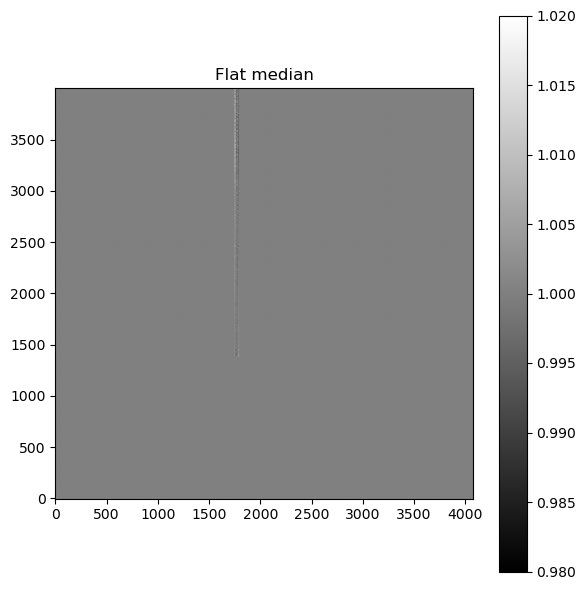

In [190]:
#%matplotlib widget
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_median,cmap="gray",origin='lower',vmin=0.98,vmax=1.02)
ax.set_title('Flat median')
fig.colorbar(im,ax=ax)
plt.tight_layout()

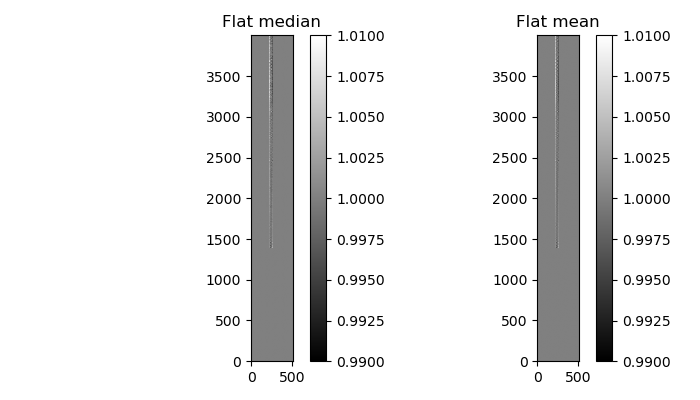

In [182]:
%matplotlib widget
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(121)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_median[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=0.99,vmax=1.01)
ax.set_title('Flat median')
fig.colorbar(im,ax=ax)

ax = fig.add_subplot(122)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_mean[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=0.99,vmax=1.01)
ax.set_title('Flat mean')
fig.colorbar(im,ax=ax)

plt.tight_layout()

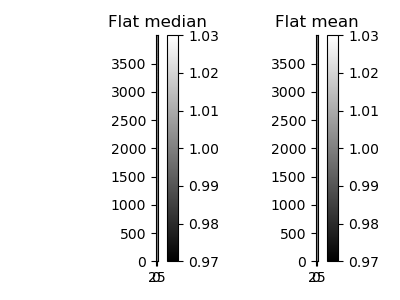

In [183]:
%matplotlib widget
fig = plt.figure(figsize=(4,3))
ax = fig.add_subplot(121)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_median[y00:y11,xint0:xint1],cmap="gray",origin='lower',vmin=0.97,vmax=1.03)
ax.set_title('Flat median')
fig.colorbar(im,ax=ax)

ax = fig.add_subplot(122)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_mean[y00:y11,xint0:xint1],cmap="gray",origin='lower',vmin=0.97,vmax=1.03)
ax.set_title('Flat mean')
fig.colorbar(im,ax=ax)

plt.tight_layout()

In [195]:
ref_row = 2250

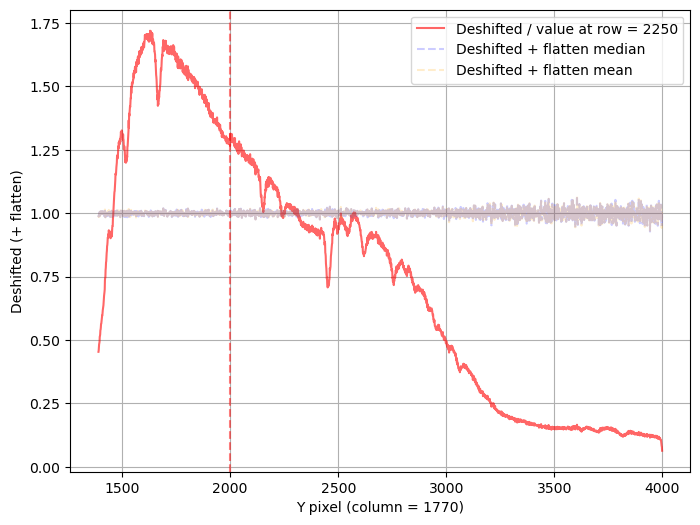

In [196]:
%matplotlib inline
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(y_spec,good_array[yint00:yint1,xcenter]/good_array[ref_row,xcenter],color='r',alpha=0.6,label='Deshifted / value at row = {0}'.format(ref_row))
ax.plot(y_spec,flat_array_median[yint00:yint1,xcenter],ls='--',color='b',alpha=0.2,label='Deshifted + flatten median')
ax.plot(y_spec,flat_array_mean[yint00:yint1,xcenter],ls='--',color='orange',alpha=0.2,label='Deshifted + flatten mean')
ax.axvline(x=2000,ls='--',color='r',alpha=0.5)
ax.grid()
ax.set_xlabel('Y pixel (column = {0})'.format(xcenter))
ax.set_ylabel('Deshifted (+ flatten)')
ax.legend(loc="best")

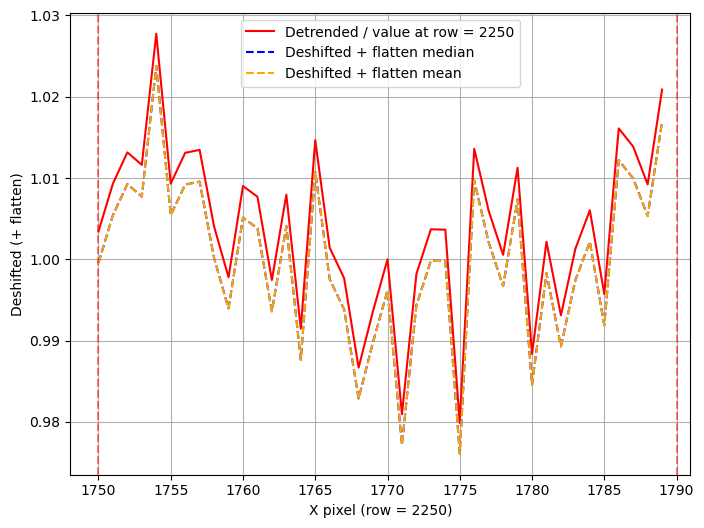

In [203]:
row_ = 2250
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(np.arange(xint0,xint1),good_array[row_,xint0:xint1]/good_array[ref_row,xcenter],color='r',alpha=1.0,label='Detrended / value at row = {0}'.format(ref_row))
ax.plot(np.arange(xint0,xint1),flat_array_median[row_,xint0:xint1],ls='--',color='b',alpha=1.0,label='Deshifted + flatten median')
ax.plot(np.arange(xint0,xint1),flat_array_mean[row_,xint0:xint1],ls='--',color='orange',alpha=1.0,label='Deshifted + flatten mean')
ax.axvline(x=xint0,ls='--',color='r',alpha=0.5)
ax.axvline(x=xint1,ls='--',color='r',alpha=0.5)
ax.grid()
ax.set_xlabel('X pixel (row = {0})'.format(row_))
ax.set_ylabel('Deshifted (+ flatten)')
ax.legend(loc="best")

In [199]:
xcenter

1770

Text(0.5, 0, 'X pixel (row = 2250)')

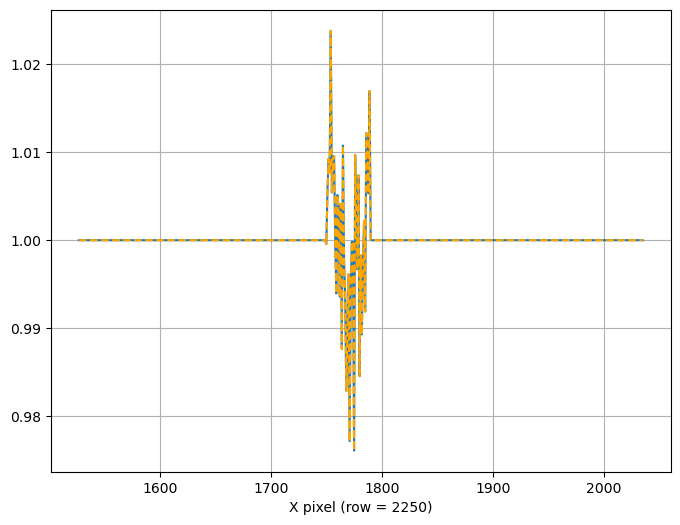

In [201]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.plot(x_ampli,flat_array_median[ref_row,x0:x1])
ax.plot(x_ampli,flat_array_mean[ref_row,x0:x1],ls='--',color='orange')
ax.grid()
ax.set_xlabel('X pixel (row = {0})'.format(ref_row))

In [102]:
yint00

1390

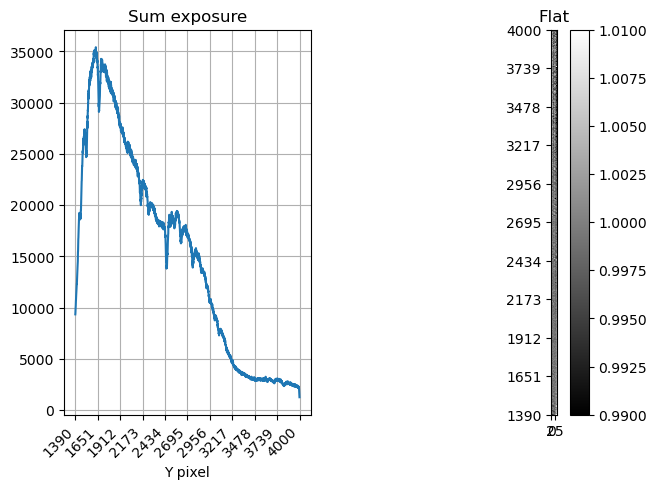

In [205]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(121)
ax.plot(np.arange(yint00,yint1)-yint00,sum_array[yint00:yint1,xcenter])
ax.set_xticks(np.linspace(yint00,yint1,11)-yint00,labels=np.linspace(yint00,yint1,11).astype('int'),ha='right',rotation=45)
ax.grid()
ax.set_xlabel('Y pixel')
ax.set_title('Sum exposure')

ax = fig.add_subplot(122)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_median[yint00:yint1,xint0:xint1],cmap="gray",origin='lower',vmin=0.99,vmax=1.01)
ax.set_yticks(np.linspace(yint00,yint1,11)-yint00,labels=np.linspace(yint00,yint1,11).astype('int'))
ax.set_title('Flat')
fig.colorbar(im,ax=ax)

#plt.tight_layout()

In [104]:
yint1-yint00

2610

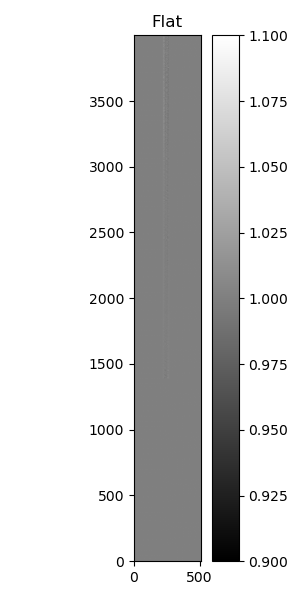

In [206]:
%matplotlib widget
fig = plt.figure(figsize=(3,6))
ax = fig.add_subplot(111)

#ylim0_ = 1500
#ylim1_ = 1600
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_median[y00:y11,x0:x1],cmap="gray",origin='lower',vmin=0.9,vmax=1.1)
#ax.axvline(x=xcenter-xint0,ls='--',color='b')
ax.set_title('Flat')
#ax.set_yticks(np.linspace(ylim0_,ylim1_,11)-ylim0_,labels=np.linspace(ylim0_,ylim1_,11).astype('int'))
fig.colorbar(im,ax=ax)
plt.tight_layout()

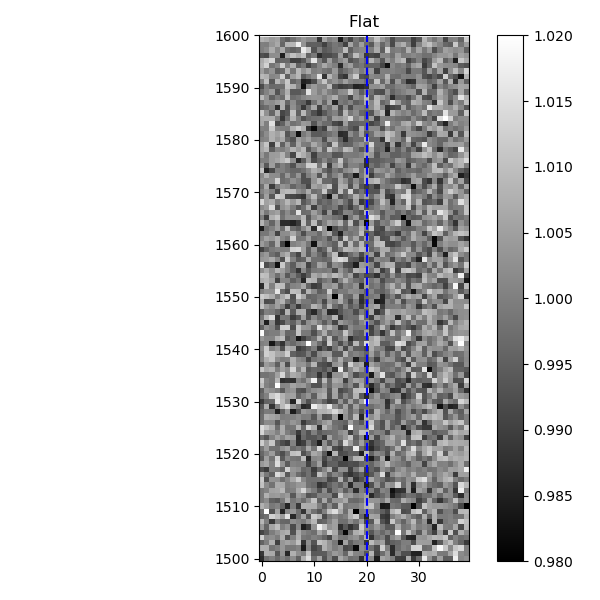

In [207]:
%matplotlib widget
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

#ylim0_ = 1500
#ylim1_ = 1600
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(flat_array_median[ylim0_:ylim1_,xint0:xint1],cmap="gray",origin='lower',vmin=0.98,vmax=1.02)
ax.axvline(x=xcenter-xint0,ls='--',color='b')
ax.set_title('Flat')
ax.set_yticks(np.linspace(ylim0_,ylim1_,11)-ylim0_,labels=np.linspace(ylim0_,ylim1_,11).astype('int'))
fig.colorbar(im,ax=ax)
plt.tight_layout()

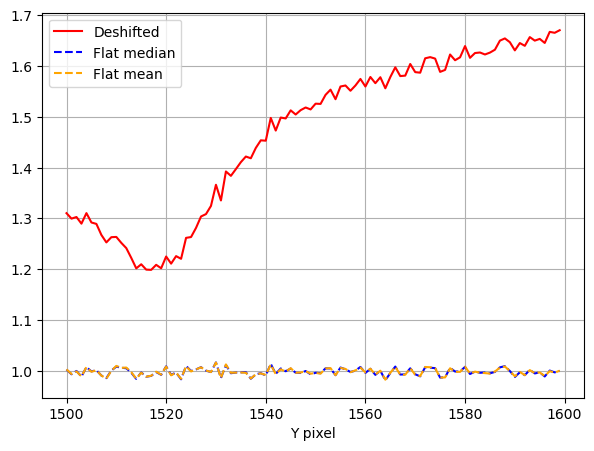

In [210]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111)
ax.plot(np.arange(ylim0_,ylim1_),good_array[ylim0_:ylim1_,xcenter]/good_array[ref_row,xcenter],color='r',label='Deshifted')
ax.plot(np.arange(ylim0_,ylim1_),flat_array_median[ylim0_:ylim1_,xcenter],ls='--',color='b',label='Flat median')
ax.plot(np.arange(ylim0_,ylim1_),flat_array_mean[ylim0_:ylim1_,xcenter],ls='--',color='orange',label='Flat mean')
ax.grid()
ax.set_xlabel('Y pixel')
ax.legend(loc="best")

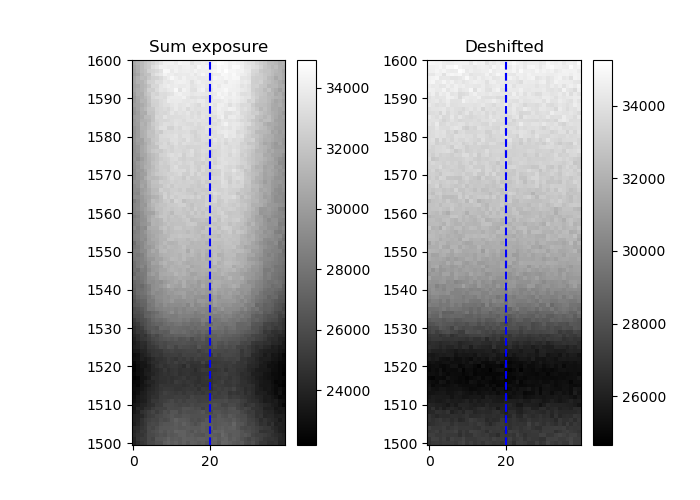

In [213]:
%matplotlib widget
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(121)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(sum_array[ylim0_:ylim1_,xint0:xint1],cmap="gray",origin='lower')#,vmin=0.99,vmax=1.01)
ax.axvline(x=xcenter-xint0,ls='--',color='b')
ax.set_title('Sum exposure')
ax.set_yticks(np.linspace(ylim0_,ylim1_,11)-ylim0_,labels=np.linspace(ylim0_,ylim1_,11).astype('int'))
fig.colorbar(im,ax=ax)

ax = fig.add_subplot(122)
#im = ax.imshow(deproj_array,cmap="gray",origin='lower',norm=LogNorm())
im = ax.imshow(good_array[ylim0_:ylim1_,xint0:xint1],cmap="gray",origin='lower')#,vmin=0.99,vmax=1.01)
ax.axvline(x=xcenter-xint0,ls='--',color='b')
ax.set_title('Deshifted')
ax.set_yticks(np.linspace(ylim0_,ylim1_,11)-ylim0_,labels=np.linspace(ylim0_,ylim1_,11).astype('int'))
fig.colorbar(im,ax=ax)


#plt.tight_layout()

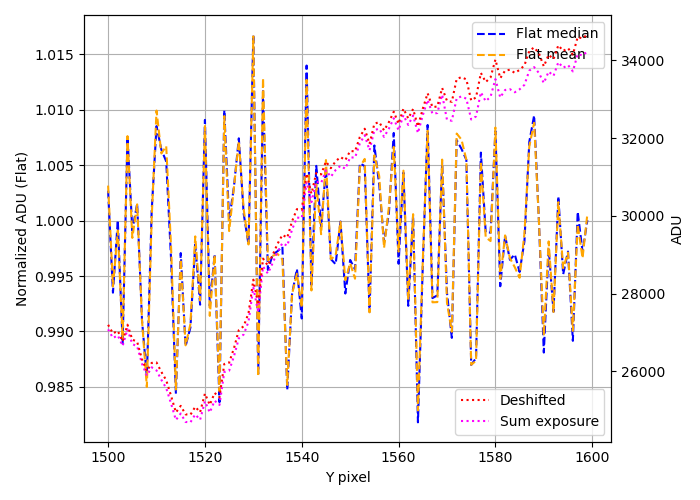

In [217]:
y0_test = 1527
y1_test = 1532

%matplotlib widget
fig = plt.figure(figsize=(7,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(np.arange(ylim0_,ylim1_),flat_array_median[ylim0_:ylim1_,xcenter],ls='--',color='b',label='Flat median')
ax1.plot(np.arange(ylim0_,ylim1_),flat_array_mean[ylim0_:ylim1_,xcenter],ls='--',color='orange',label='Flat mean')
ax2.plot(np.arange(ylim0_,ylim1_),good_array[ylim0_:ylim1_,xcenter],ls=':',color='r',label='Deshifted')
ax2.plot(np.arange(ylim0_,ylim1_),sum_array[ylim0_:ylim1_,xcenter],ls=':',color='magenta',label='Sum exposure',zorder=-1)
ax1.grid()
ax1.set_xlabel('Y pixel')
ax1.set_ylabel('Normalized ADU (Flat)')
ax2.set_ylabel('ADU')
ax1.legend(loc="best")
ax2.legend(loc="lower right")
plt.tight_layout()

# Save in fits file 

In [218]:
save_exp_sum = True
save_flat = True

In [219]:
if save_exp_sum or save_flat:
    outdir = os.path.join(outdir_base,outdir_label.format(obs_day))
    if os.path.exists(outdir)==False:
        os.mkdir(outdir)

In [220]:
if save_exp_sum:
    filename_out = 'horizontal_shift_exposure_sum_{0}_{1}_pseudo-postisrccd.fits'.format(obs_day,physical_filter.replace('~','-'))

    fullfilename_out=os.path.join(outdir,filename_out)

    print(f">>>>  output filename {filename_out}")

    hdr = fits.Header()

    for key,value in md.items():
        hdr[str(key)]=value

    if hdr['OBJECT']=='MU-COL':
        hdr['OBJECT'] = 'HD38666'
    # need this    
    hdr["AMEND"] = hdr["AMSTART"]
    try: 
        airmass_ = hdr["AIRMASS"]
    except:
        airmass_ = (hdr["AMEND"] + hdr["AMSTART"])/2.
        hdr["AIRMASS"] = airmass_

    # be aware weather data may be missing
    if hdr["AIRTEMP"] == None:
        hdr["AIRTEMP"] = 10.0

    if hdr["PRESSURE"] == None:
        hdr["PRESSURE"] = 744.

    if hdr["HUMIDITY"] == None:
        hdr["HUMIDITY"] = 50.

    if hdr["WINDSPD"] == None:
        hdr["WINDSPD"] = 5.

    if hdr["WINDDIR"] == None:
        hdr["WINDDIR"] = 0.   

    if hdr["SEEING"] == None:
        hdr["SEEING"] = 1.15


    # Be carefull for Spectractor, 2 hdu units are necessary

    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(sum_array)
    #image_hdu = fits.ImageHDU(arr)

    hdu_list = fits.HDUList([primary_hdu, image_hdu])

    hdu_list.writeto(fullfilename_out,overwrite=True)


>>>>  output filename horizontal_shift_exposure_sum_20230926_empty-holo4_003_pseudo-postisrccd.fits


In [221]:
if save_flat:
    filename_out = 'horizontal_shift_star_median_flat_{0}_{1}_pseudo-postisrccd.fits'.format(obs_day,physical_filter.replace('~','-'))

    fullfilename_out=os.path.join(outdir,filename_out)

    print(f">>>>  output filename {filename_out}")

    hdr = fits.Header()

    for key,value in md_isr.items():
        hdr[str(key)]=value
        
    hdr['IMGTYPE'] = 'FLAT-SHIFT-STAR'

    if hdr['OBJECT']=='MU-COL':
        hdr['OBJECT'] = 'HD38666'
    # need this    
    hdr["AMEND"] = hdr["AMSTART"]
    try: 
        airmass_ = hdr["AIRMASS"]
    except:
        airmass_ = (hdr["AMEND"] + hdr["AMSTART"])/2.
        hdr["AIRMASS"] = airmass_

    # be aware weather data may be missing
    if hdr["AIRTEMP"] == None:
        hdr["AIRTEMP"] = 10.0

    if hdr["PRESSURE"] == None:
        hdr["PRESSURE"] = 744.

    if hdr["HUMIDITY"] == None:
        hdr["HUMIDITY"] = 50.

    if hdr["WINDSPD"] == None:
        hdr["WINDSPD"] = 5.

    if hdr["WINDDIR"] == None:
        hdr["WINDDIR"] = 0.   

    if hdr["SEEING"] == None:
        hdr["SEEING"] = 1.15


    # Be carefull for Spectractor, 2 hdu units are necessary

    primary_hdu = fits.PrimaryHDU(header=hdr)
    image_hdu = fits.ImageHDU(flat_array_median)
    #image_hdu = fits.ImageHDU(arr)

    hdu_list = fits.HDUList([primary_hdu, image_hdu])

    hdu_list.writeto(fullfilename_out,overwrite=True)


>>>>  output filename horizontal_shift_star_median_flat_20230926_empty-holo4_003_pseudo-postisrccd.fits
